In [80]:
from time import time
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime, timedelta
import ensemble_kalman_filter as enkf
from rebayes_mini import datagen
from rebayes_mini import callbacks
# from rebayes_mini.methods import student_t_filter as stf
# from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import robust_filter as rkf
# from rebayes_mini.methods import generalised_bayes_filter as gbf
from bayes_opt import BayesianOptimization
from tqdm import tqdm
import os

In [81]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.style.use("default")
plt.rcParams["font.size"] = 18

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
delta = 0.1
dynamics_covariance = 0.1
obs_covariance = 10.0

name_dgen = "common"
# name_dgen = "added_mean"
save_dir ='../dataset/2dtracking' + str(name_dgen) + '/'
save_flag = False

match name_dgen:
    case "common":
        dgen = datagen.MovingObject2D(
            delta, dynamics_covariance, obs_covariance
        )
    case "st":
        dgen = datagen.GaussStMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            dof_observed=2.01
        )
    case "mean":
        dgen = datagen.GaussMeanOutlierMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            outlier_proba=0.05,
            outlier_scale=2.0,
        )
    case "added_mean":
        dgen = datagen.GaussOneSideOutlierMovingObject2D(
            delta, dynamics_covariance, obs_covariance,
            outlier_proba=0.05,
            outlier_minval=-100,
            outlier_maxval=100
        )
    case _:
        raise ValueError(f"Dgen {name_dgen} not valid")

(100, 200, 4) (100, 200, 2)


(np.float64(-11.702618980407715),
 np.float64(45.5597318649292),
 np.float64(-70.18463706970215),
 np.float64(111.37624931335449))

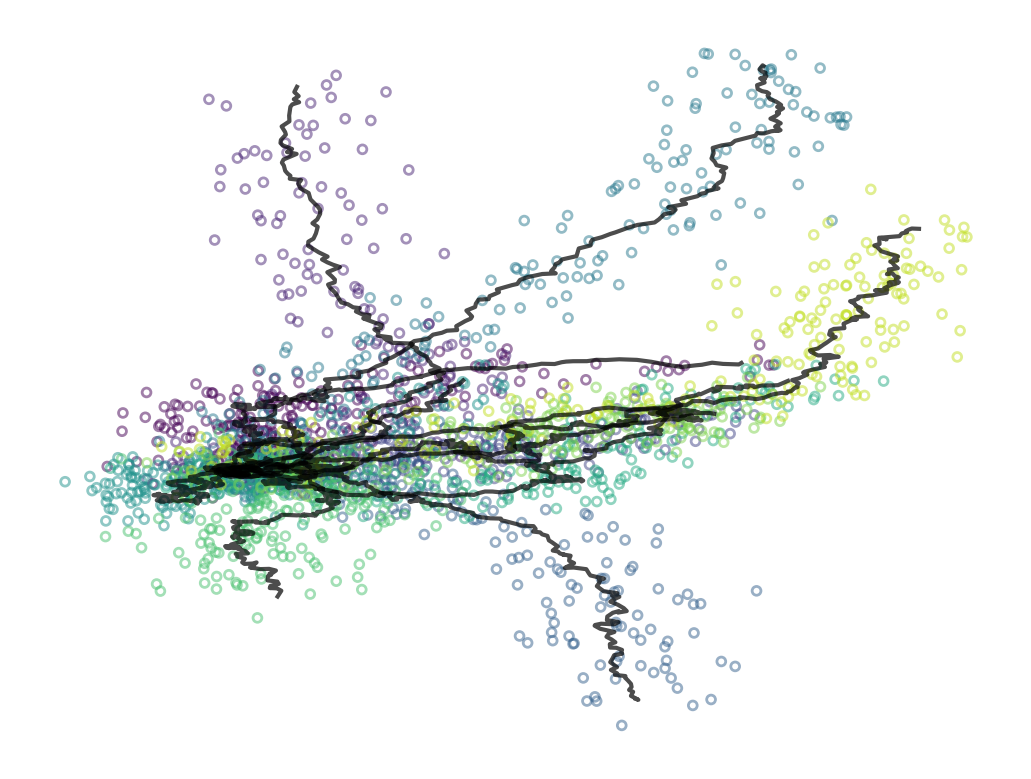

In [83]:
key = jax.random.PRNGKey(314)
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])

n_steps = 200
n_samples = 100
keys = jax.random.split(key, n_samples)

colors = plt.cm.viridis(jnp.linspace(0, 1, n_samples))
datasets = jax.vmap(dgen.sample, in_axes=(0, None, None))(keys, initial_mean, n_steps)
key_eval, _ = jax.random.split(key)
yv = datasets["observed"]
statev = datasets["latent"]
print(statev.shape, yv.shape)
datasets_cpu = jax.tree.map(lambda x: np.array(x[::10]), datasets)
for i, color in enumerate(colors[::10]):
    dataset = jax.tree.map(lambda x: x[i], datasets_cpu)
    plt.plot(*dataset["latent"][:, :2].T, c="black", alpha=0.7)
    plt.scatter(*dataset["observed"].T, edgecolor=color, color="none", s=10, alpha=0.5)
    
plt.axis("off")

In [84]:
ys = yv.reshape(-1, 2)
xs = statev.reshape(-1, 4)
print(xs.shape,ys.shape)

(20000, 4) (20000, 2)


In [85]:
# 生成时间序列
start_time = datetime(2024, 6, 7, 13, 0, 0)
time_interval = timedelta(seconds=1)
time_series = [start_time + i * time_interval for i in range(xs.shape[0])]

# 创建 DataFrame
column_names = [f'x_{i}' for i in range(1, xs.shape[1] + 1)]
df = pd.DataFrame(xs, columns=column_names)
df.insert(0, 'date', time_series)

print(df.head())

                 date       x_1       x_2       x_3       x_4
0 2024-06-07 13:00:00  0.379820 -0.433132  0.591681  0.451700
1 2024-06-07 13:00:01  0.667540 -0.078880  0.923025  0.236054
2 2024-06-07 13:00:02  0.858156 -0.062636  0.792993  0.469924
3 2024-06-07 13:00:03  1.077784 -0.023404  0.543567  0.827982
4 2024-06-07 13:00:04  0.811851 -0.591008  0.932614  1.172590


In [86]:
# 保存为 CSV 文件
if save_flag:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    csv_path = save_dir + 'tracking.csv'
    df.to_csv(csv_path, index=False)
    # 创建 DataFrame
    column_names = [f'y_{i}' for i in range(1, ys.shape[1] + 1)]
    dfy = pd.DataFrame(ys, columns=column_names)
    dfy.insert(0, 'date', time_series)

    print(dfy.head())
    csv_path = save_dir + 'tracking_obs.csv'
    dfy.to_csv(csv_path, index=False)

In [87]:
def latent_fn(z):
    return dgen.transition_matrix @ z

def measurement_fn(z, _):
    return dgen.projection_matrix @ z

time_methods = {}
hist_methods = {}
errs_methods = {}
configs = {}
np.set_printoptions(precision=4)

In [88]:
def calculate_mse(errs):
    return jnp.mean(jnp.square(errs))
def calculate_mae(errs):
    return jnp.mean(jnp.abs(errs), axis=(1, 2))

def calculate_rmse(errs):
    return jnp.sqrt(jnp.mean(jnp.square(errs), axis=(1, 2)))

def calculate_test_error(errs):
    mse = calculate_mse(errs)
    mae = calculate_mae(errs)
    rmse = calculate_rmse(errs) 
    print(f'mse:{mse}, mae:{mae}, rmse:{rmse}')
    return {
        'mse':mse, 
        'mae':mae,
        'rmse':rmse
    }

## Kalman Filter

In [89]:
@jax.jit
def filter_kf(x0, measurements, state):
    nsteps = len(measurements)
    agent_imq = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=1e8,
    )
    init_bel = agent_imq.init_bel(x0, cov=1e-8)
    filterfn = partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_bel, measurements, jnp.ones(n_steps))

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist

In [90]:
method = "KF"

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_kf(state[0], y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
print(hist_bel.shape)
errs = (hist_bel - statev)
errs_test = errs[int(errs.shape[0] * 0.8):]
tim = np.mean(np.array(times)[int(errs.shape[0] * 0.8):]) / n_samples
errs_methods[method] = calculate_test_error(errs_test)
time_methods[method] = tim

100%|██████████| 100/100 [00:00<00:00, 304.73it/s]

(100, 200, 4)
mse:1.4959663152694702, mae:[0.9141 1.0603 0.8733 0.9275 0.9844 0.9856 1.0345 0.9064 0.9226 0.9946
 0.9875 0.8985 0.982  0.9897 1.0036 0.9907 1.0231 1.1017 0.8923 1.0594], rmse:[1.1164 1.3114 1.0672 1.1835 1.2181 1.2394 1.3098 1.1447 1.1875 1.228
 1.2438 1.1203 1.22   1.206  1.2489 1.2385 1.3042 1.3622 1.125  1.3375]


In [91]:
from rebayes_mini.methods.particle_filter import ParticleFilter
def filter_pf(ff, hh, x0, num_particle,measurements, state, key_eval):
    agent_particle=ParticleFilter(ff, hh,
        dynamics_covariance=jnp.eye(state.shape[-1]),
        observation_covariance=jnp.eye(measurements.shape[-1]),
        n_particles=num_particle
        )
    key_init_particles, key_scan = jax.random.split(key_eval, 2)
    init_particles=agent_particle._initialize_particles(key_init_particles, x0, cov=1.0)
    filterfn = partial(agent_particle.scan, callback_fn=callbacks.get_updated_mean)
    _, hist = filterfn(init_particles, key_scan, measurements, jnp.ones(state.shape[0]))
    err = hist - state
    return err, hist

In [92]:
method = "PF"

hist_bel = []
times = []

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    key_pf = jax.random.split(key_eval, 1)[0]
    _, run = filter_pf(latent_fn, measurement_fn, state[0], 1000, y, state,  key_eval=key_pf)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
errs = (hist_bel - statev)
errs_test = errs[int(errs.shape[0] * 0.8):]
tim = np.mean(np.array(times)[int(errs.shape[0] * 0.8):]) / n_samples
errs_methods[method] = calculate_test_error(errs_test)
time_methods[method] = tim

100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


mse:9.095846176147461, mae:[2.2012 3.2616 2.2321 2.0686 2.3355 1.9001 3.3261 2.0312 2.2323 2.9441
 1.9627 2.1234 2.143  1.7793 2.2507 2.036  1.9282 2.3265 2.0349 1.9648], rmse:[2.8742 4.4397 2.9222 2.6499 2.962  2.3972 4.458  2.6764 2.8459 4.0312
 2.58   2.8683 2.8376 2.3336 2.8711 2.825  2.4774 3.0224 2.5406 2.4789]


In [93]:
from filtering_methods import run_filtering
# methods = ['EKF', 'EnKF', 'EnKFI', 'HubEnKF', 'EnKFS']
methods = ['EKF', 'WLFIMQ', 'WLFSQ', 'WLFMD', 'PF']
# methods = ['PF']
ff = latent_fn
hh = measurement_fn
yv_test = yv[int(n_samples * 0.8):]
statev_test = statev[int(n_samples * 0.8):]
parameter_range = (1e-1, 20)
_, _, _ = run_filtering(methods, yv_test, statev_test, key_eval, ff, hh, parameter_range, num_particle=1000)

EKF


100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


WLFIMQ


100%|██████████| 20/20 [00:03<00:00,  5.76it/s]


WLFSQ


100%|██████████| 20/20 [00:03<00:00,  5.50it/s]


WLFMD


100%|██████████| 20/20 [00:03<00:00,  5.65it/s]


PF


100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


Done
RMSE
{'EKF': Array(2.222, dtype=float32),
 'PF': Array(2.9333, dtype=float32),
 'WLFIMQ': Array(1.4355, dtype=float32),
 'WLFMD': Array(16.4285, dtype=float32),
 'WLFSQ': Array(2.2238, dtype=float32)}
Time
{'EKF': np.float64(0.8775392770767213),
 'PF': np.float64(3.2516733407974243),
 'WLFIMQ': np.float64(0.8682932257652283),
 'WLFMD': np.float64(0.8859127163887024),
 'WLFSQ': np.float64(0.9092485904693604)}


In [94]:

@jax.jit
def filter_wlfmd(x0, threshold, measurements, state):
    agent = rkf.ExtendedKalmanFilterMD(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        threshold=threshold
    )
    
    init_bel = agent.init_bel(x0, cov=1e-8)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfmd(threshold):
    err, _ = filter_wlfmd(statev[0][0], threshold, yv[0], statev[0])
    return -err.max()

bo = BayesianOptimization(
    bo_filter_wlfmd,
    pbounds={
        "threshold": (1e-1, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=20)
print(bo.max)



|   iter    |  target   | threshold |
-------------------------------------
{'target': np.float64(-18.25663948059082), 'params': {'threshold': np.float64(18.345784271710052)}}


In [95]:
method = "WoLF-MD"
threshold = bo.max["params"]["threshold"]
configs[method] = bo.max["params"]

hist_bel=[]
times = []
for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_wlfmd(state[0], threshold, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = np.array(times)
print(method)
errs = (hist_bel - statev)
errs_test = errs[int(errs.shape[0] * 0.8):]
errs_methods[method] = calculate_test_error(errs_test)
tim = np.mean(np.array(times)[int(errs.shape[0] * 0.8):]) / n_samples
errs_methods[method] = calculate_test_error(errs_test)
time_methods[method] = tim

100%|██████████| 100/100 [00:00<00:00, 259.16it/s]

WoLF-MD
mse:1.4959663152694702, mae:[0.9141 1.0603 0.8733 0.9275 0.9844 0.9856 1.0345 0.9064 0.9226 0.9946
 0.9875 0.8985 0.982  0.9897 1.0036 0.9907 1.0231 1.1017 0.8923 1.0594], rmse:[1.1164 1.3114 1.0672 1.1835 1.2181 1.2394 1.3098 1.1447 1.1875 1.228
 1.2438 1.1203 1.22   1.206  1.2489 1.2385 1.3042 1.3622 1.125  1.3375]
mse:1.4959663152694702, mae:[0.9141 1.0603 0.8733 0.9275 0.9844 0.9856 1.0345 0.9064 0.9226 0.9946
 0.9875 0.8985 0.982  0.9897 1.0036 0.9907 1.0231 1.1017 0.8923 1.0594], rmse:[1.1164 1.3114 1.0672 1.1835 1.2181 1.2394 1.3098 1.1447 1.1875 1.228
 1.2438 1.1203 1.22   1.206  1.2489 1.2385 1.3042 1.3622 1.125  1.3375]


In [96]:
@jax.jit
def filter_wlfimq(x0, threshold, measurements, state):
    agent = rkf.ExtendedKalmanFilterIMQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=threshold
    )
    
    init_bel = agent.init_bel(x0, cov=1e-8)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfimq(threshold):
    err, _ = filter_wlfimq(statev[0][0], threshold, yv[0], statev[0])
    return -err.max()

bo = BayesianOptimization(
    bo_filter_wlfimq,
    pbounds={
        "threshold": (1e-1, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=20)
print(bo.max)

method = "WoLF-IMQ"
threshold = bo.max["params"]["threshold"]
configs[method] = bo.max["params"]
times = []
hist_bel=[]

for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_wlfimq(state[0], threshold, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = np.array(times)
print(method)
errs = (hist_bel - statev)
errs_test = errs[int(errs.shape[0] * 0.8):]
errs_methods[method] = calculate_test_error(errs_test)
tim = np.mean(np.array(times)[int(errs.shape[0] * 0.8):]) / n_samples
errs_methods[method] = calculate_test_error(errs_test)
time_methods[method] = tim

|   iter    |  target   | threshold |
-------------------------------------
| 5         | -18.26    | 18.37     |
| 22        | -18.26    | 20.0      |
{'target': np.float64(-18.255577087402344), 'params': {'threshold': np.float64(19.997361758373774)}}


100%|██████████| 100/100 [00:00<00:00, 331.47it/s]

WoLF-IMQ
mse:1.491117000579834, mae:[0.899  1.0608 0.8621 0.9214 0.9815 0.985  1.0398 0.9066 0.91   0.9881
 0.9877 0.8979 0.9916 0.9977 0.9863 0.9975 1.0211 1.1056 0.8862 1.0705], rmse:[1.0987 1.3144 1.0544 1.1829 1.2138 1.2342 1.3185 1.1433 1.1707 1.2154
 1.2414 1.1197 1.2306 1.2143 1.2294 1.2512 1.2998 1.3676 1.1194 1.3465]
mse:1.491117000579834, mae:[0.899  1.0608 0.8621 0.9214 0.9815 0.985  1.0398 0.9066 0.91   0.9881
 0.9877 0.8979 0.9916 0.9977 0.9863 0.9975 1.0211 1.1056 0.8862 1.0705], rmse:[1.0987 1.3144 1.0544 1.1829 1.2138 1.2342 1.3185 1.1433 1.1707 1.2154
 1.2414 1.1197 1.2306 1.2143 1.2294 1.2512 1.2998 1.3676 1.1194 1.3465]


In [97]:
@jax.jit
def filter_wlfsq(x0, threshold, measurements, state):
    agent = rkf.ExtendedKalmanFilterSQ(
        latent_fn, measurement_fn,
        dynamics_covariance=dgen.dynamics_covariance,
        observation_covariance=dgen.observation_covariance,
        soft_threshold=threshold
    )
    
    init_bel = agent.init_bel(x0, cov=1e-8)
    
    _, hist = agent.scan(
        init_bel, measurements, jnp.ones(n_steps), callback_fn=callbacks.get_updated_mean
    )

    err = jnp.sqrt(jnp.power(hist - state, 2).sum(axis=0))
    return err, hist


@jax.jit
def bo_filter_wlfsq(threshold):
    err, _ = filter_wlfsq(statev[0][0], threshold, yv[0], statev[0])
    return -err.max()

bo = BayesianOptimization(
    bo_filter_wlfsq,
    pbounds={
        "threshold": (1e-1, 20)
    },
    random_state=314,
    verbose=1
)
bo.maximize(init_points=20, n_iter=20)
print(bo.max)

method = "WoLF-SQ"
threshold = bo.max["params"]["threshold"]
configs[method] = bo.max["params"]

hist_bel=[]
times = []
for y, state in tqdm(zip(yv, statev), total=n_samples): 
    tinit = time()
    _, run = filter_wlfimq(state[0], threshold, y, state)
    tend = time()
    
    hist_bel.append(run)
    times.append(tend - tinit)

hist_bel = np.stack(hist_bel)

hist_methods[method] = hist_bel
time_methods[method] = np.array(times)
print(method)
errs = (hist_bel - statev)
errs_test = errs[int(errs.shape[0] * 0.8):]
errs_methods[method] = calculate_test_error(errs_test)
tim = np.mean(np.array(times)[int(errs.shape[0] * 0.8):]) / n_samples
errs_methods[method] = calculate_test_error(errs_test)
time_methods[method] = tim

|   iter    |  target   | threshold |
-------------------------------------
{'target': np.float64(-18.2666015625), 'params': {'threshold': np.float64(18.345784271710052)}}


100%|██████████| 100/100 [00:00<00:00, 576.84it/s]

WoLF-SQ
mse:1.4913243055343628, mae:[0.8968 1.0613 0.8605 0.9207 0.9812 0.9851 1.0409 0.9068 0.9081 0.9875
 0.9883 0.8978 0.9935 0.9996 0.9839 0.9991 1.0208 1.1068 0.8854 1.0728], rmse:[1.0961 1.3154 1.0528 1.1835 1.2133 1.2336 1.3203 1.1432 1.1682 1.2139
 1.2415 1.1197 1.2329 1.2163 1.2266 1.254  1.2993 1.3689 1.1189 1.3485]
mse:1.4913243055343628, mae:[0.8968 1.0613 0.8605 0.9207 0.9812 0.9851 1.0409 0.9068 0.9081 0.9875
 0.9883 0.8978 0.9935 0.9996 0.9839 0.9991 1.0208 1.1068 0.8854 1.0728], rmse:[1.0961 1.3154 1.0528 1.1835 1.2133 1.2336 1.3203 1.1432 1.1682 1.2139
 1.2415 1.1197 1.2329 1.2163 1.2266 1.254  1.2993 1.3689 1.1189 1.3485]


In [98]:
llm_results = np.load("/home/liushiqi/lsq/LLM-Filter/results/LLMFilter_tracking_results.npz")
llm_err = llm_results['estimation'] - llm_results['state']
llm_err = llm_err.reshape(20, -1, 4)
print(llm_err.shape)
errs_methods['LLM-Filter'] = calculate_test_error(llm_err)
print(np.array(errs_methods['LLM-Filter']['rmse']).shape)

(20, 200, 4)
mse:1.009994387626648, mae:[0.4714 1.107  1.1645 0.5317 0.6604 0.8151 0.4908 0.9095 0.6395 0.8537
 0.6193 0.4337 0.8875 1.1782 0.5978 0.6939 0.6115 0.5942 0.8134 0.9846], rmse:[0.5969 1.5255 1.4697 0.6292 0.8459 1.0741 0.5996 1.2626 0.8287 1.0685
 0.745  0.5073 1.1493 1.4882 0.72   0.9352 0.75   0.7253 0.9801 1.2324]
(20,)


In [99]:
kalmannet_results = np.load("/home/liushiqi/lsq/LLM-Filter/results/KalmanNet_tracking_results.npz")
kalmannet_err = kalmannet_results['preds'] - kalmannet_results['trues']
kalmannet_err = kalmannet_err.reshape(20, -1, 4)
print(kalmannet_err.shape)
errs_methods['KalmanNet'] = calculate_test_error(kalmannet_err)
print(np.array(errs_methods['KalmanNet']['rmse']).shape)

(20, 200, 4)
mse:1.3599919080734253, mae:[0.8508 1.0129 0.8616 0.899  0.9064 0.9606 1.0046 0.8358 0.8873 0.8111
 0.9818 0.7642 0.9339 1.021  0.9169 0.8943 0.9502 0.9009 0.7739 1.0199], rmse:[1.0574 1.2915 1.1118 1.2072 1.1627 1.2103 1.308  1.0783 1.1307 1.0038
 1.2257 0.9671 1.1695 1.2745 1.1599 1.128  1.2783 1.168  0.986  1.3137]
(20,)


In [100]:
print(statev.shape)
true = statev[int(statev.shape[0] * 0.8):]
print(true.shape)
print(true[0][1])
llm_true = llm_results['state']
llm_estimation = llm_results['estimation']
llm_obs = llm_results['obs']
print(llm_true[1450:1470])
# print(llm_estimation[0:3])
# print(llm_obs[0:3])



(100, 200, 4)
(20, 200, 4)
[ 0.5062 -0.453   1.45    1.1799]
[[-2.7777e-01 -2.8617e-01  4.3437e-02 -2.6217e-01]
 [-2.7367e-01 -2.7488e-01  4.7328e-02 -1.0667e-01]
 [-2.4959e-01 -2.8935e-01  5.6348e-02  4.8865e-02]
 [-2.4333e-01 -3.0270e-01  1.6148e-01  1.1330e-02]
 [-2.6174e-01 -2.8851e-01  1.4826e-01  9.1996e-03]
 [-2.5049e-01 -2.8827e-01  5.6814e-02 -2.0380e-01]
 [-2.3496e-01 -2.8484e-01 -6.6924e-04 -4.1231e-02]
 [-2.6488e-01 -2.8560e-01 -1.0460e-01  1.6634e-02]
 [-2.6141e-01 -2.8585e-01 -4.3422e-02  8.1242e-02]
 [-2.4703e-01 -2.7222e-01 -9.5865e-02  8.9611e-03]
 [-2.5145e-01 -2.7724e-01 -1.9356e-02 -2.1929e-01]
 [-2.3851e-01 -2.7377e-01 -8.3159e-02 -3.7927e-01]
 [-2.0730e-01 -2.5607e-01  2.4155e-03 -5.2813e-01]
 [-1.8743e-01 -2.4757e-01 -6.9341e-02 -5.7554e-01]
 [-1.9625e-01 -2.5065e-01  7.4883e-02 -6.3261e-01]
 [-1.9467e-01 -2.5344e-01 -1.2529e-01 -4.2557e-01]
 [-1.7356e-01 -2.5512e-01  1.0392e-01 -4.8370e-01]
 [-1.6351e-01 -2.6109e-01  2.2308e-01 -6.3675e-01]
 [-1.4915e-01 -2.3725

In [101]:
kalmannet_true = kalmannet_results['trues']
target = kalmannet_true[0][0]

closest_points = []
indices = []

# Find the closest point for each dimension
for dim in range(statev.shape[2]):
    # Compute absolute differences for the current dimension
    differences = np.abs(statev[:, :, dim] - target[dim])
    # Find the index of the minimum difference
    min_index = np.unravel_index(np.argmin(differences), differences.shape)
    # Retrieve the closest value and save it
    closest_points.append(statev[min_index[0], min_index[1], dim])
    indices.append(min_index)

# Output results
for dim, (value, idx) in enumerate(zip(closest_points, indices)):
    print(f"Dimension {dim}: Closest Value = {value}, Index = {idx}")

Dimension 0: Closest Value = 0.2800064980983734, Index = (np.int64(80), np.int64(0))
Dimension 1: Closest Value = 0.5067623853683472, Index = (np.int64(20), np.int64(22))
Dimension 2: Closest Value = 0.3925376832485199, Index = (np.int64(73), np.int64(144))
Dimension 3: Closest Value = 0.46266019344329834, Index = (np.int64(58), np.int64(46))


In [102]:
# print key of errs_methods
print(errs_methods.keys())
if "WoLF-SQ" in errs_methods:
    errs_methods["WKF"] = errs_methods.pop("WoLF-SQ")
print(np.mean(errs_methods['LLM-Filter']['rmse']))
print(np.mean(errs_methods['KalmanNet']['rmse']))
print(np.mean(errs_methods['WKF']['rmse'])) 

dict_keys(['KF', 'PF', 'WoLF-MD', 'WoLF-IMQ', 'WoLF-SQ', 'LLM-Filter', 'KalmanNet'])
0.95668155
1.1616242
1.2183354


In [103]:
import pandas as pd
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.style.use("default")
plt.rcParams["font.size"] = 18
cmap = {
    "LLM-Filter": "crimson",
    "KalmanNet": "lightseagreen",
    "KF": "dodgerblue",
    "WKF": "gold",
    "PF": "darkorange",
    # "REKF": "crimson",
    # "ICKF":"gold",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
# 过滤掉不需要的 'WoLF-IMQ' 和 'WoLF-MD' 数据
errs_methods_filtered = {k: v for k, v in errs_methods.items() if k not in ['WoLF-IMQ', 'WoLF-MD']}
for method, metrics in errs_methods_filtered.items():
    for metric in ["rmse", "mse", "mae"]:
        if isinstance(metrics.get(metric), jnp.ndarray):
            errs_methods_filtered[method][metric] = np.array(metrics[metric])  # Convert to NumPy array
# 转换 JAX 数组为 NumPy 数组并整理为 DataFrame
all_data = []
for method, metrics in errs_methods_filtered.items():
    rmse_values = metrics["rmse"]
    if isinstance(rmse_values, jnp.ndarray):  # 转换 JAX 数组
        rmse_values = np.array(rmse_values)
    for value in rmse_values:
        all_data.append({"method": method, "rmse": value})

df = pd.DataFrame(all_data)

/tmp/ipykernel_2293632/3499706625.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Methods", loc="best", title_fontsize='13', fontsize='11')  # 设置图例标题和字体大小


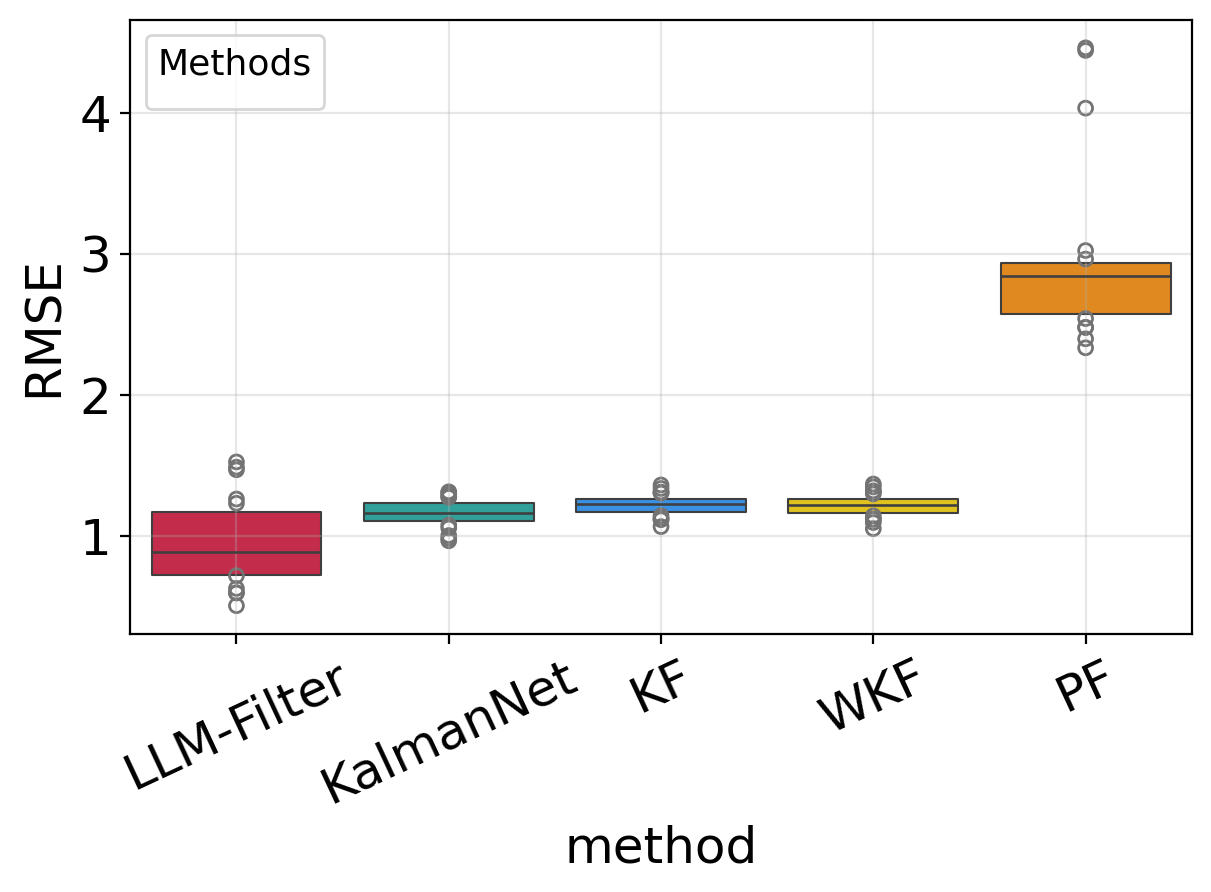

In [105]:
# 确保methods顺序
methods = ["LLM-Filter", "KalmanNet", "KF", "WKF", "PF"]
df['method'] = pd.Categorical(df['method'], categories=methods, ordered=True)
# 创建箱型图
sns.boxenplot(
    x="method",  # 方法作为 X 轴
    y="rmse",    # RMSE 作为 Y 轴
    data=df,     # 数据源
    hue="method",  # 根据 "method" 来着色
    palette=cmap,  # 调色板
    hue_order=methods,  # 确保绘制顺序与 methods 一致
    # showfliers=False  # 隐藏离群点
)

# 设置图例为各方法名称A
# plt.yscale("log")  # 使用对数刻度
plt.legend(title="Methods", loc="best", title_fontsize='13', fontsize='11')  # 设置图例标题和字体大小
plt.ylabel("RMSE")  # 设置 Y 轴标签
plt.xticks(rotation=25)  # 旋转 X 轴标签，避免重叠
plt.grid(alpha=0.3)  # 设置网格透明度
plt.tight_layout()  # 自动调整布局
plt.show()

In [106]:
rmse = np.array([1.0407, 1.1662, 1.2231, 1.2212])
costtime = np.array([0.8397, 0.03102, 0.8393, 0.8883])
methods = ["LLM-Filter", "KalmanNet", "KF", "WKF"]
cmap = {
    "LLM-Filter": "lightseagreen",
    "KalmanNet": "darkorange",
    "KF": "dodgerblue",
    "WKF": "#dda0dd",
}
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

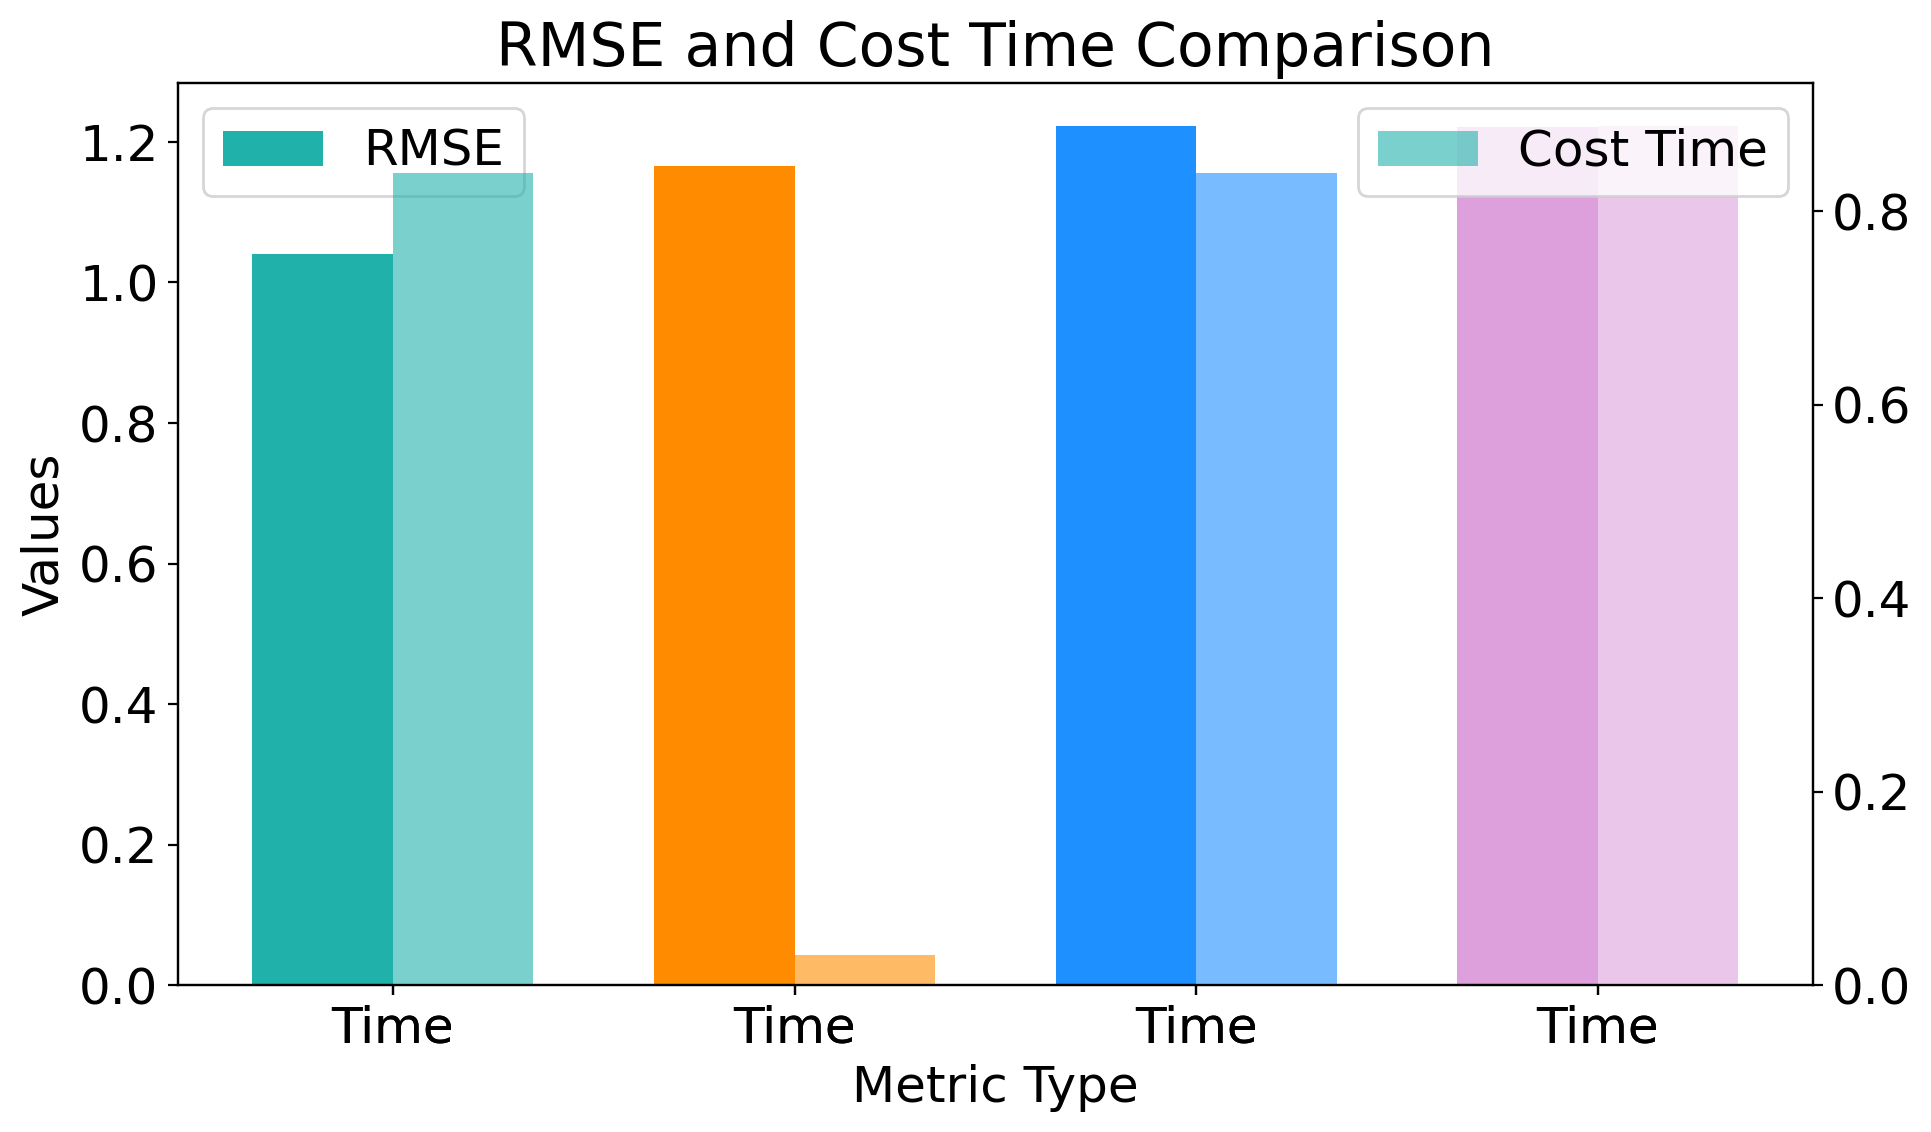

In [107]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define x positions for RMSE and Cost Time
x_rmse = np.arange(len(rmse))
x_costtime = np.arange(len(costtime))

# Create bar chart for RMSE
width = 0.35  # bar width
bars_rmse = ax1.bar(x_rmse - width/2, rmse, width, label="RMSE", color=[cmap[method] for method in methods])

# Creating a second y-axis for Cost Time
ax2 = ax1.twinx()
bars_costtime = ax2.bar(x_costtime + width/2, costtime, width, label="Cost Time", color=[cmap[method] for method in methods], alpha=0.6)

# Labeling the axes and title
ax1.set_xticks(np.concatenate([x_rmse, x_costtime]))  # Merge x-axis ticks
ax1.set_xticklabels(['RMSE'] * len(rmse) + ['Time'] * len(costtime))  # Set labels to 'RMSE' and 'Time'
ax1.set_xlabel('Metric Type')
ax1.set_ylabel('Values', color='black')
ax1.set_title('RMSE and Cost Time Comparison')

# Show legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.show()

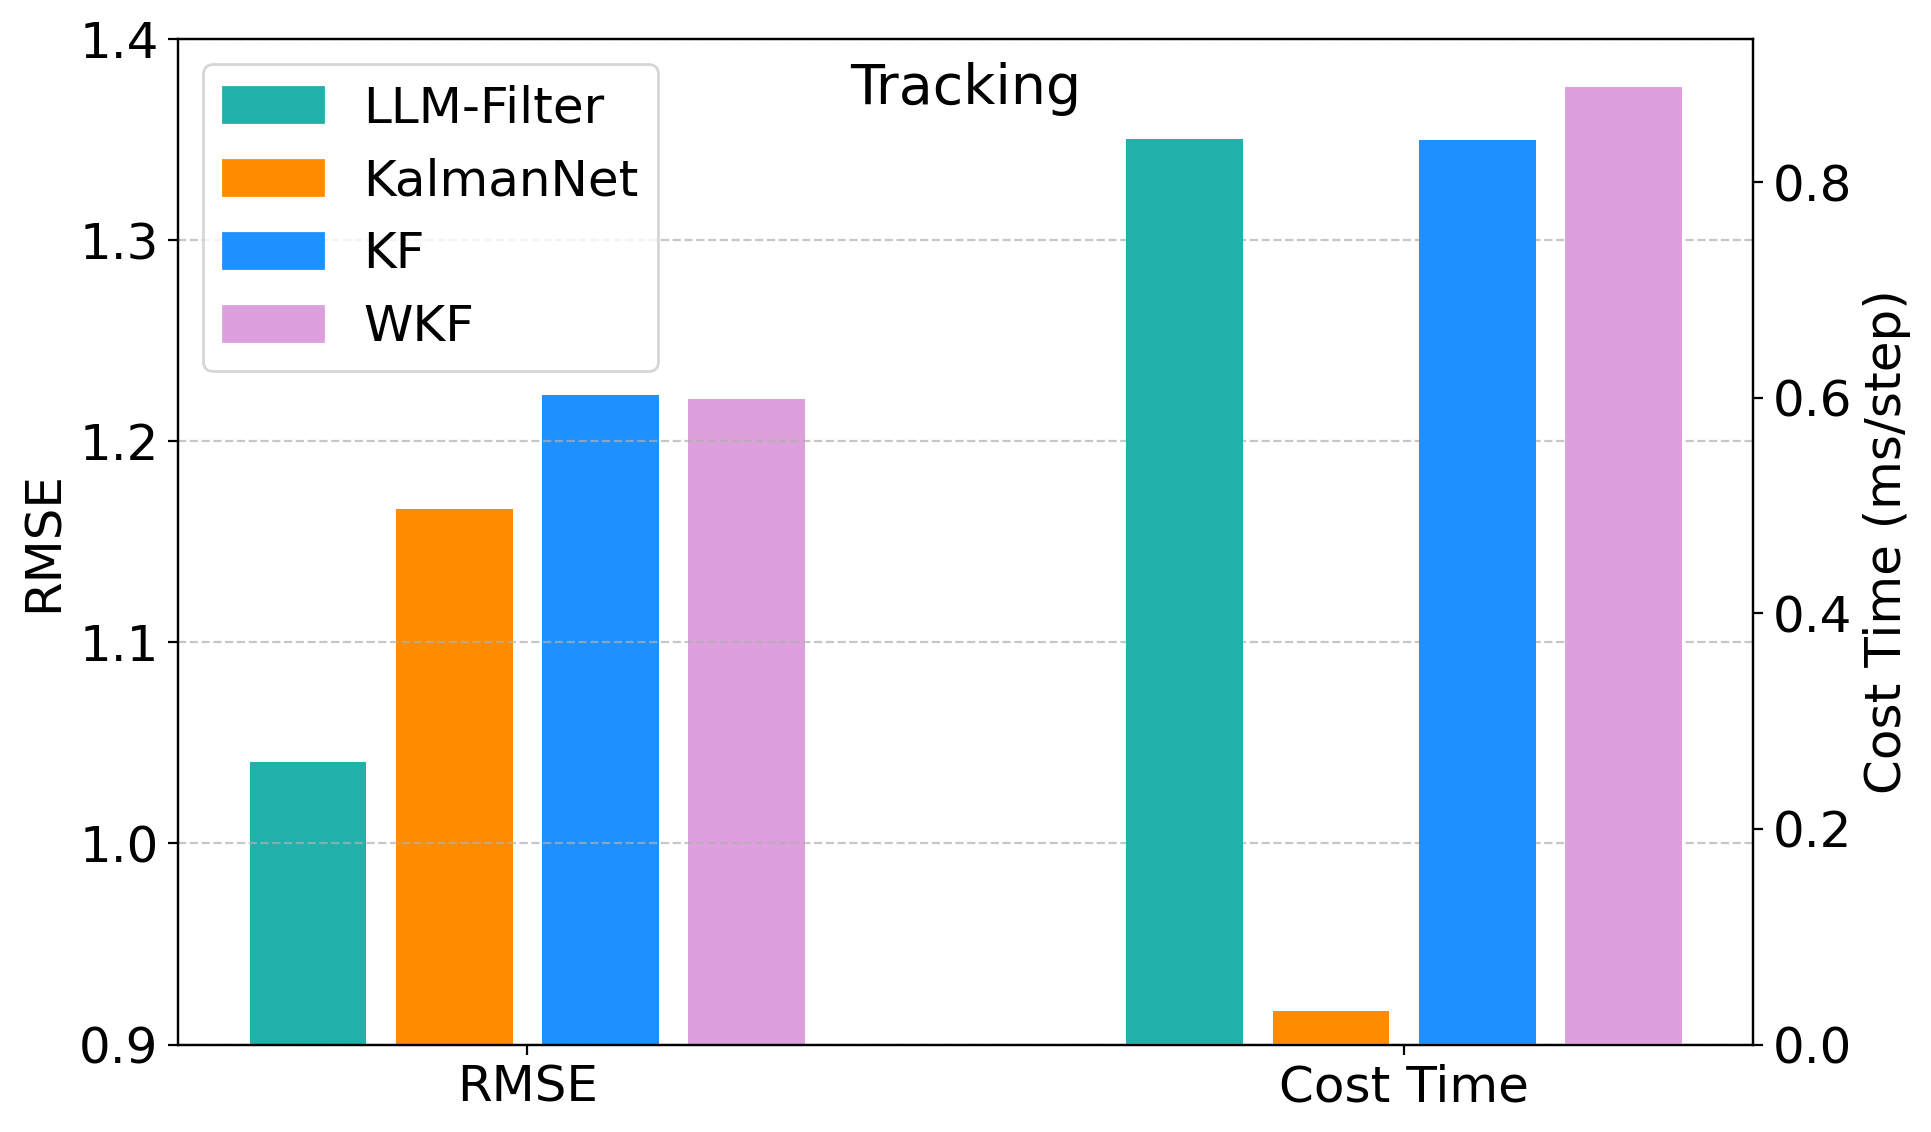

In [ ]:
# 条形图宽度
bar_width = 0.8
index = np.arange(len(methods))  # 四个方法
index_2 = np.arange(len(methods)+2, 2 * len(methods)+2)
# 创建子图
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制 RMSE 的条形图，所有条形图都放在 "RMSE" 这一坐标下
ax1.bar(index, rmse, bar_width, label='RMSE', color=[cmap[m] for m in methods])

# 设置横坐标，只有一个 "RMSE" 标签
ax1.set_xticks([1.5, 7.5])  # 只有一个横坐标标签
ax1.set_xticklabels(['RMSE','Cost Time'])  # 设置为 RMSE 标签
ax2 = ax1.twinx()
ax2.bar(index_2, costtime, bar_width, label='Costtime', color=[cmap[m] for m in methods])
# 设置 y 轴标签和标题
ax1.set_ylim(0.9, 1.4)
ax1.set_ylabel('RMSE')
ax2.set_ylabel('Speed (ms/step)')

ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
# 添加图例
handles_rmse = [plt.Rectangle((0, 0), 1, 1, color=cmap[m]) for m in methods]
ax1.legend(handles=handles_rmse, labels=methods, loc="upper left")
ax1.text(0.5, 0.95, 'Tracking', ha='center', va='center', transform=ax1.transAxes, fontsize=20, color='black')

# 显示图形
plt.tight_layout()
plt.savefig(r'/home/liushiqi/lsq/LLM-Filter/plot/figures/tracking_rmse_costtime.png', dpi=600, bbox_inches='tight')

In [109]:
print(np.mean([2.5095, 2.6815, 2.5747, 6.7377, 2.9397]))

3.48862


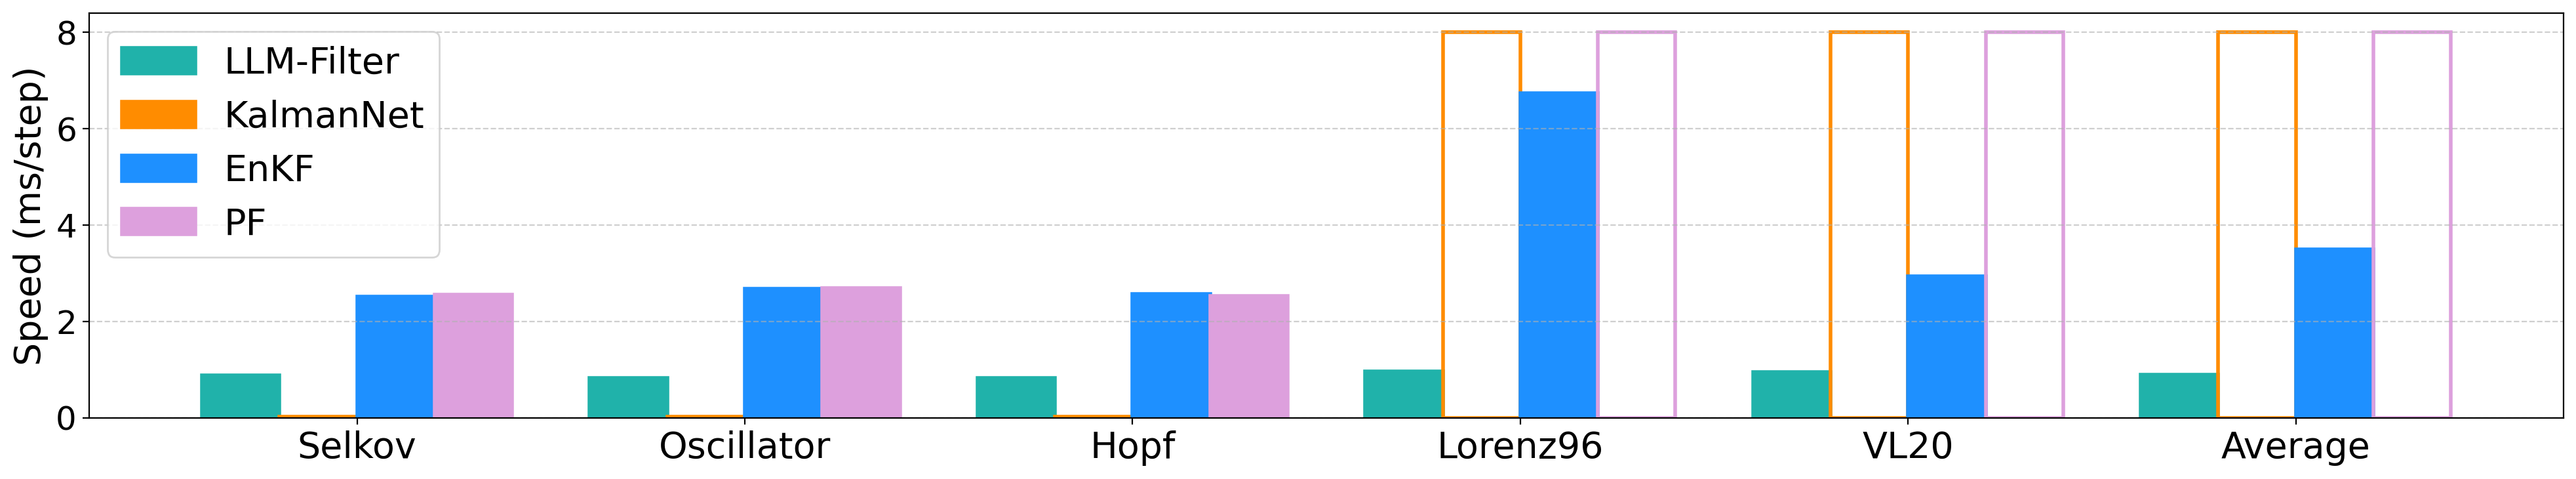

In [122]:
# Data preparation
data = {
    "System": ["Selkov", "Oscillator", "Hopf", "Lorenz96", "VL20", "Average"],
    "LLM-Filter": [0.8766, 0.8299, 0.8245, 0.9577, 0.9503, 0.8878],
    "KalmanNet": [0.02523, 0.02465, 0.02314, np.nan, np.nan, np.nan],
    "EnKF": [2.5095, 2.6815, 2.5747, 6.7377, 2.9397, 3.48862],
    "PF": [2.5607, 2.6886, 2.5287, np.nan, np.nan, np.nan],
}
df = pd.DataFrame(data)
systems = df["System"]
methods = ["LLM-Filter", "KalmanNet", "EnKF", "PF"]

# Colors for each method
cmap = {
    "LLM-Filter": "lightseagreen",
    "KalmanNet": "darkorange",
    "EnKF": "dodgerblue", 
    "PF": "#dda0dd",
}

x = np.arange(len(systems))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(20, 4))
# Plot each method
for i, method in enumerate(methods):
    values = df[method]
    
    # Colors: solid for valid values, empty (no fill) for NaN
    colors = [cmap[method] if not np.isnan(v) else 'none' for v in values]
    edge_colors = [cmap[method] if not np.isnan(v) else cmap[method] for v in values]
    
    # Draw bars
    bars = ax.bar(
        x + i * width, 
        np.nan_to_num(values, nan=8),  # NaN bars will have height 20
        width, 
        label=method, 
        color=colors, 
        edgecolor=edge_colors, 
        linewidth=2  # Make edge thicker for clarity
    )

    # Add "NaN" text for missing values
    # for bar, value in zip(bars, values):
    #     if value==8:
    #         ax.text(
    #             bar.get_x() + bar.get_width() / 2,  # Center of the bar
    #             4,  # Height slightly above the bar
    #             'NaN', 
    #             ha='center', 
    #             va='center', 
    #             fontsize=14, 
    #             color='black'
    #         )

ax.set_ylabel('Speed (ms/step)', fontsize=20)
ax.set_xticks(x + width * (len(methods) - 1) / 2)
ax.set_xticklabels(systems, fontsize=20)
ax.legend(fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.savefig('/home/liushiqi/lsq/LLM-Filter/plot/figures/runtime_1.pdf', dpi=600, bbox_inches='tight')

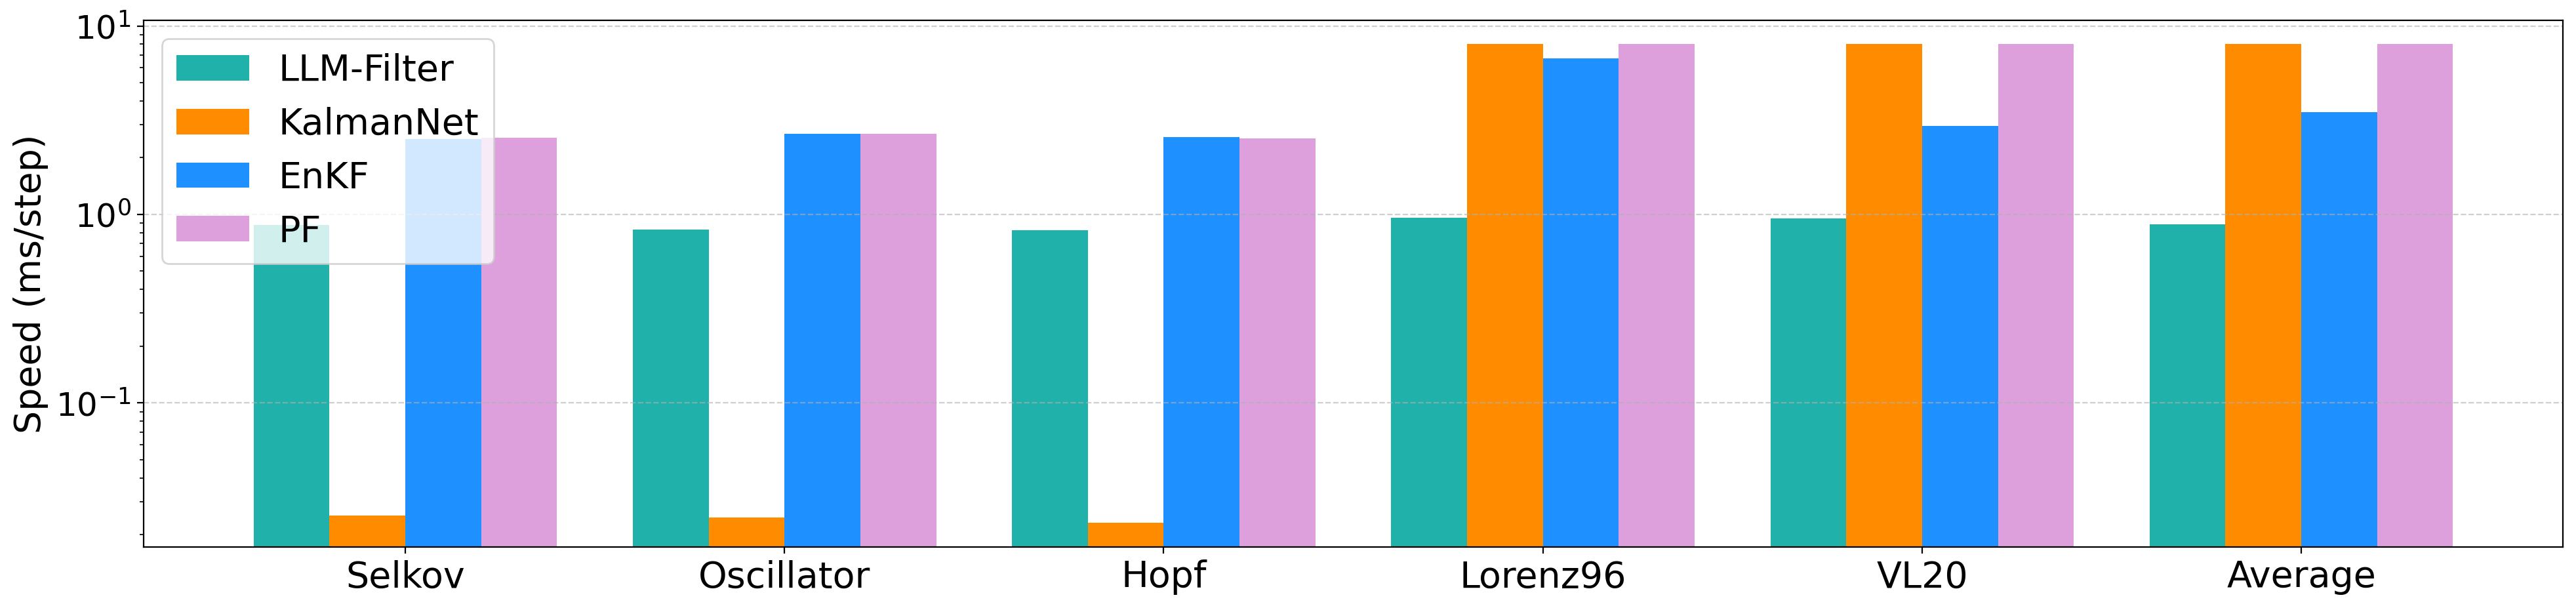

In [111]:
x = np.arange(len(systems))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(20, 5))

for i, method in enumerate(methods):
    values = df[method]
    # Define colors for bars, use gray for NaN values
    colors = [cmap[method] for v in values]
    bars = ax.bar(x + i * width, np.nan_to_num(values, nan=0), width, label=method, color=colors)
    
    # Add "NaN" text for missing values
    for bar, value in zip(bars, values):
        if value==0:
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                2,  # Place text slightly above the baseline
                'NaN', 
                ha='center', 
                va='center', 
                fontsize=20, 
                color='black'
            )
# Formatting
ax.set_yscale('log')
ax.set_ylabel('Speed (ms/step)', fontsize=20)
ax.set_xticks(x + width * (len(methods) - 1) / 2)
ax.set_xticklabels(systems, fontsize=20)
ax.legend(fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()

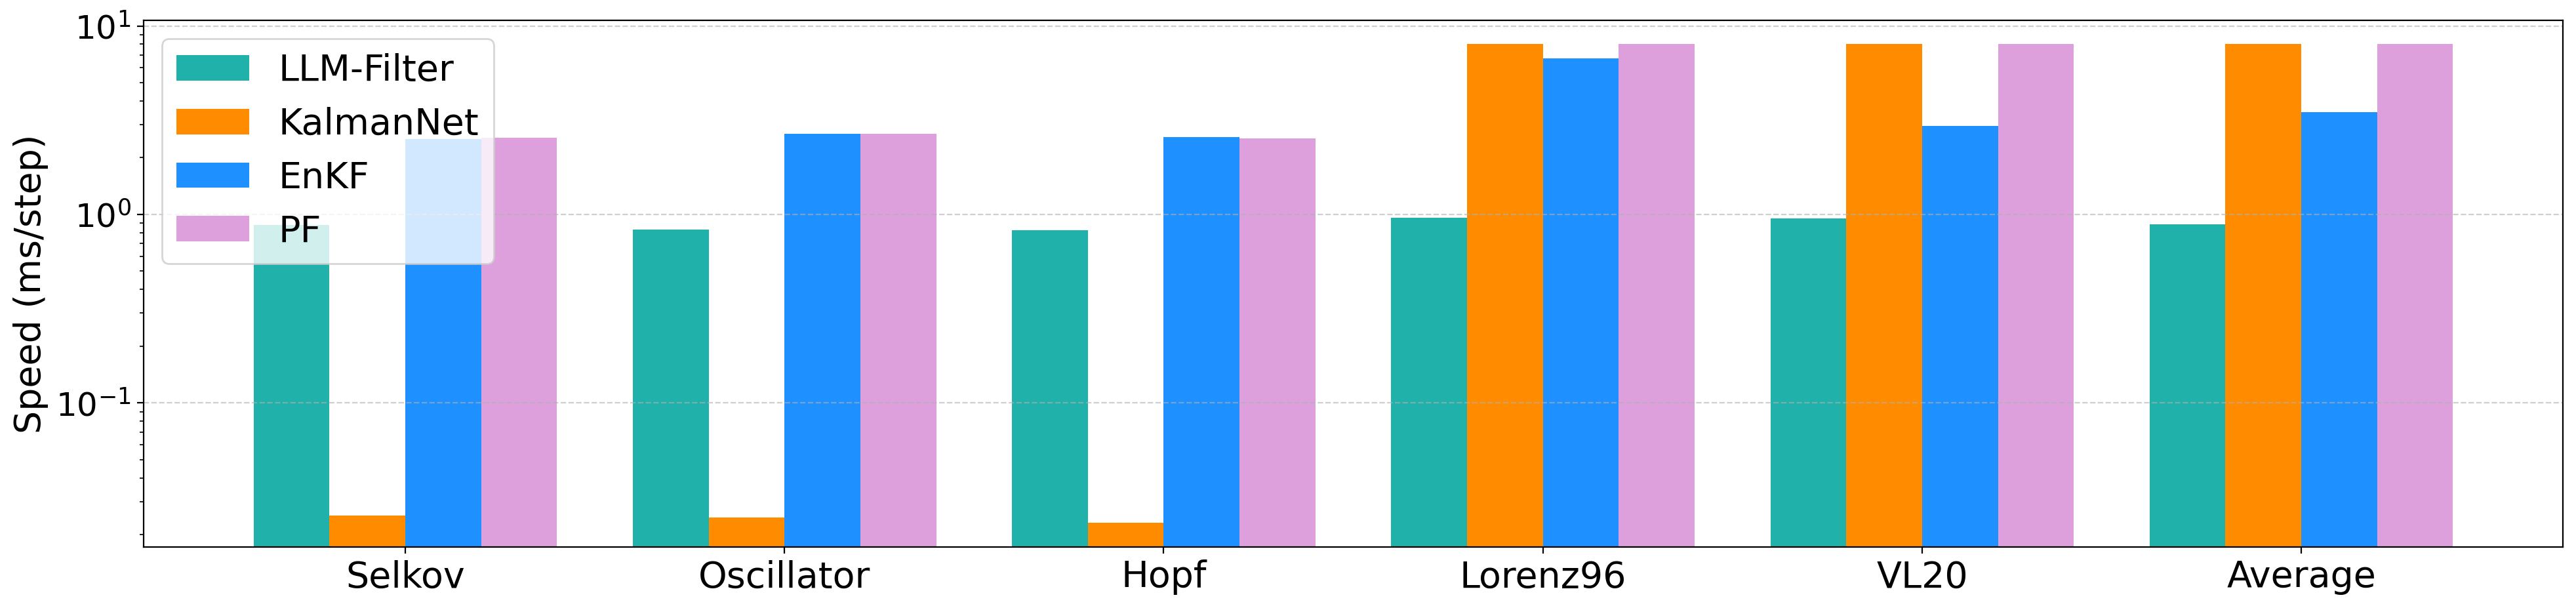

In [112]:
fig, ax = plt.subplots(figsize=(20, 5))

for i, method in enumerate(methods):
    values = df[method]
    # Define colors for bars, normal for non-NaN, gray for NaN hollow bars
    colors = [cmap[method] if not np.isnan(v) else 'none' for v in values]
    edge_colors = [cmap[method] for v in values]

    # Draw solid bars for valid values, hollow bars for NaN (height at 20)
    bars = ax.bar(
        x + i * width,
        np.nan_to_num(values, nan=20),  # Use 20 for NaN bars as height
        width,
        label=method,
        color=colors,
        edgecolor=edge_colors,
        linewidth=[0 if not np.isnan(v) else 2 for v in values],
    )

    # Add "NaN" text for missing values
    for bar, value in zip(bars, values):
        if np.isnan(value):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                22,  # Slightly above hollow bar height
                'NaN',
                ha='center',
                va='center',
                fontsize=14,
                color='black',
            )

# Formatting
ax.set_yscale('log')
ax.set_ylabel('Speed (ms/step)', fontsize=20)
ax.set_xticks(x + width * (len(methods) - 1) / 2)
ax.set_xticklabels(systems, fontsize=20)
ax.legend(fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()

In [113]:
states = llm_results['state'].reshape(20, -1, 4)
estimations = llm_results['estimation'].reshape(20, -1, 4)

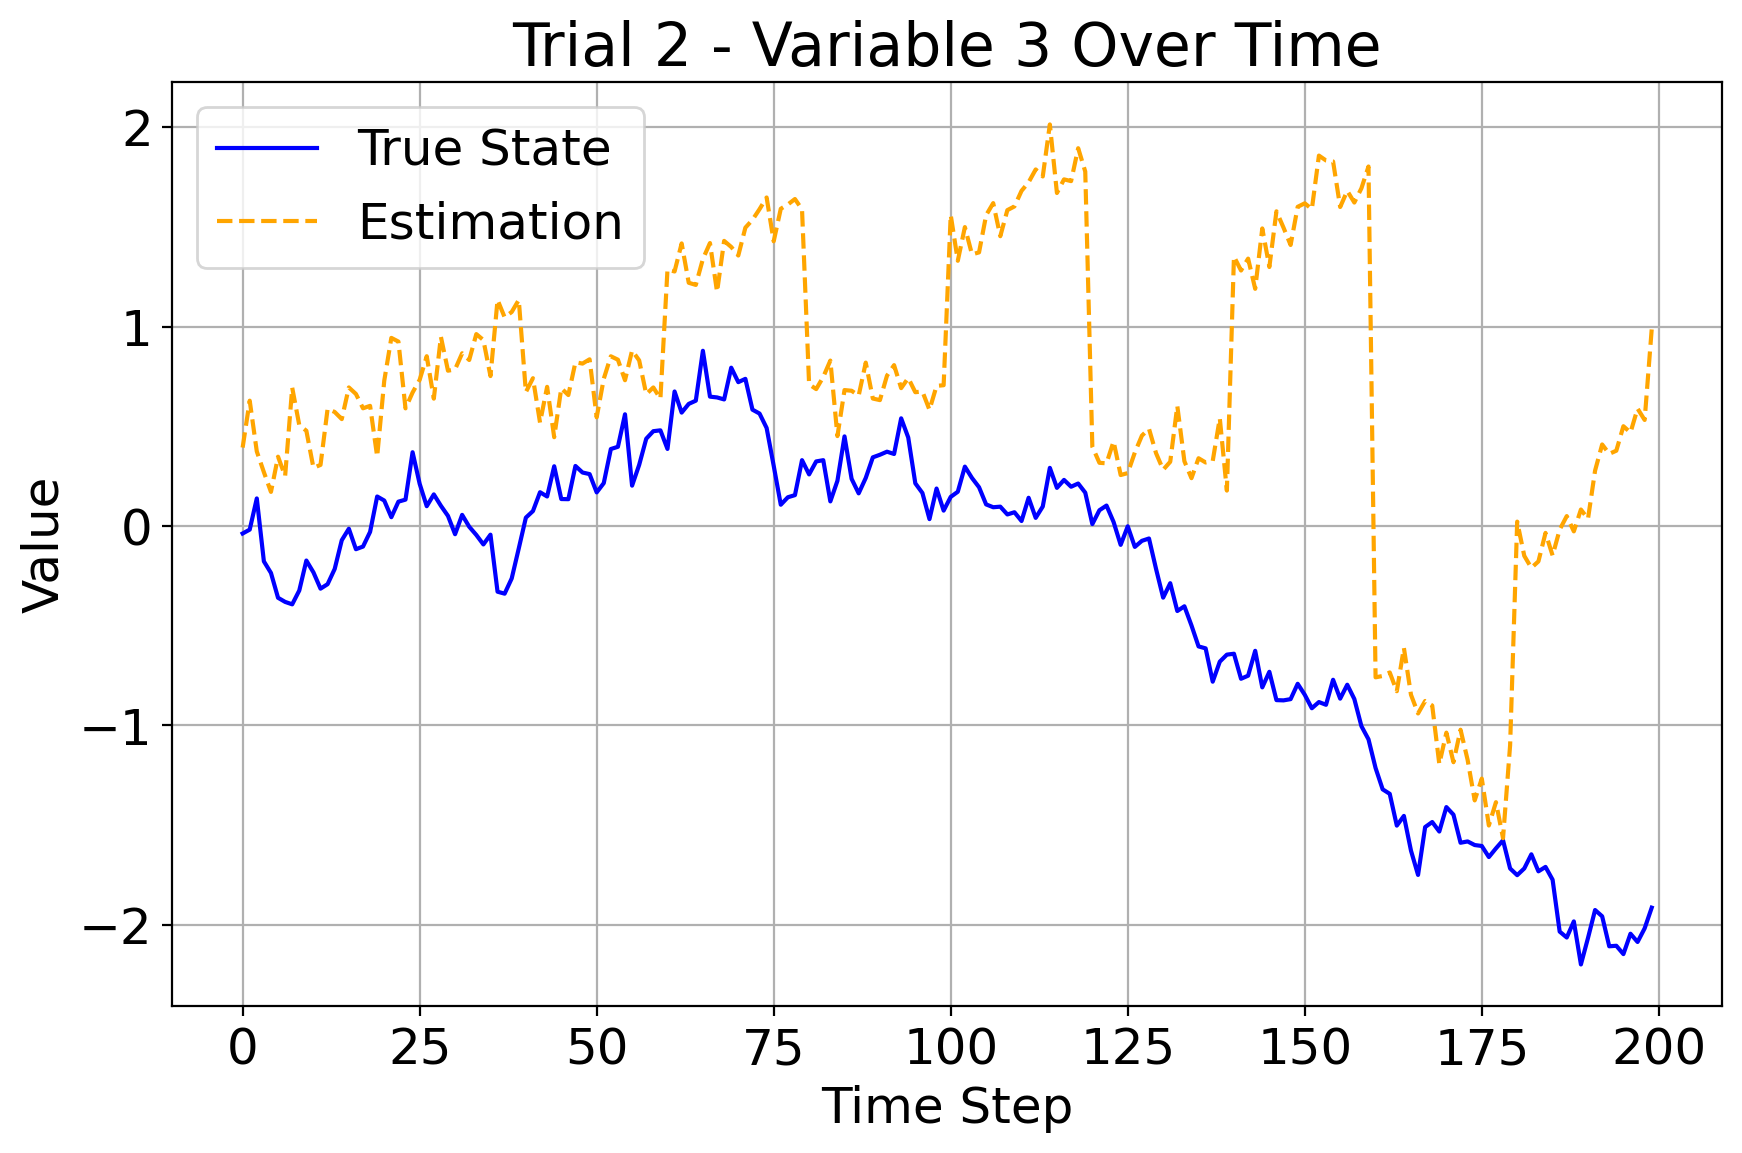

In [114]:
trial_index = 1
variable_index = 2

state_values = states[trial_index, :, variable_index]
estimation_values = estimations[trial_index, :, variable_index]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(state_values, label='True State', linestyle='-', color='blue')
plt.plot(estimation_values, label='Estimation', linestyle='--', color='orange')
plt.title(f'Trial {trial_index + 1} - Variable {variable_index + 1} Over Time')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

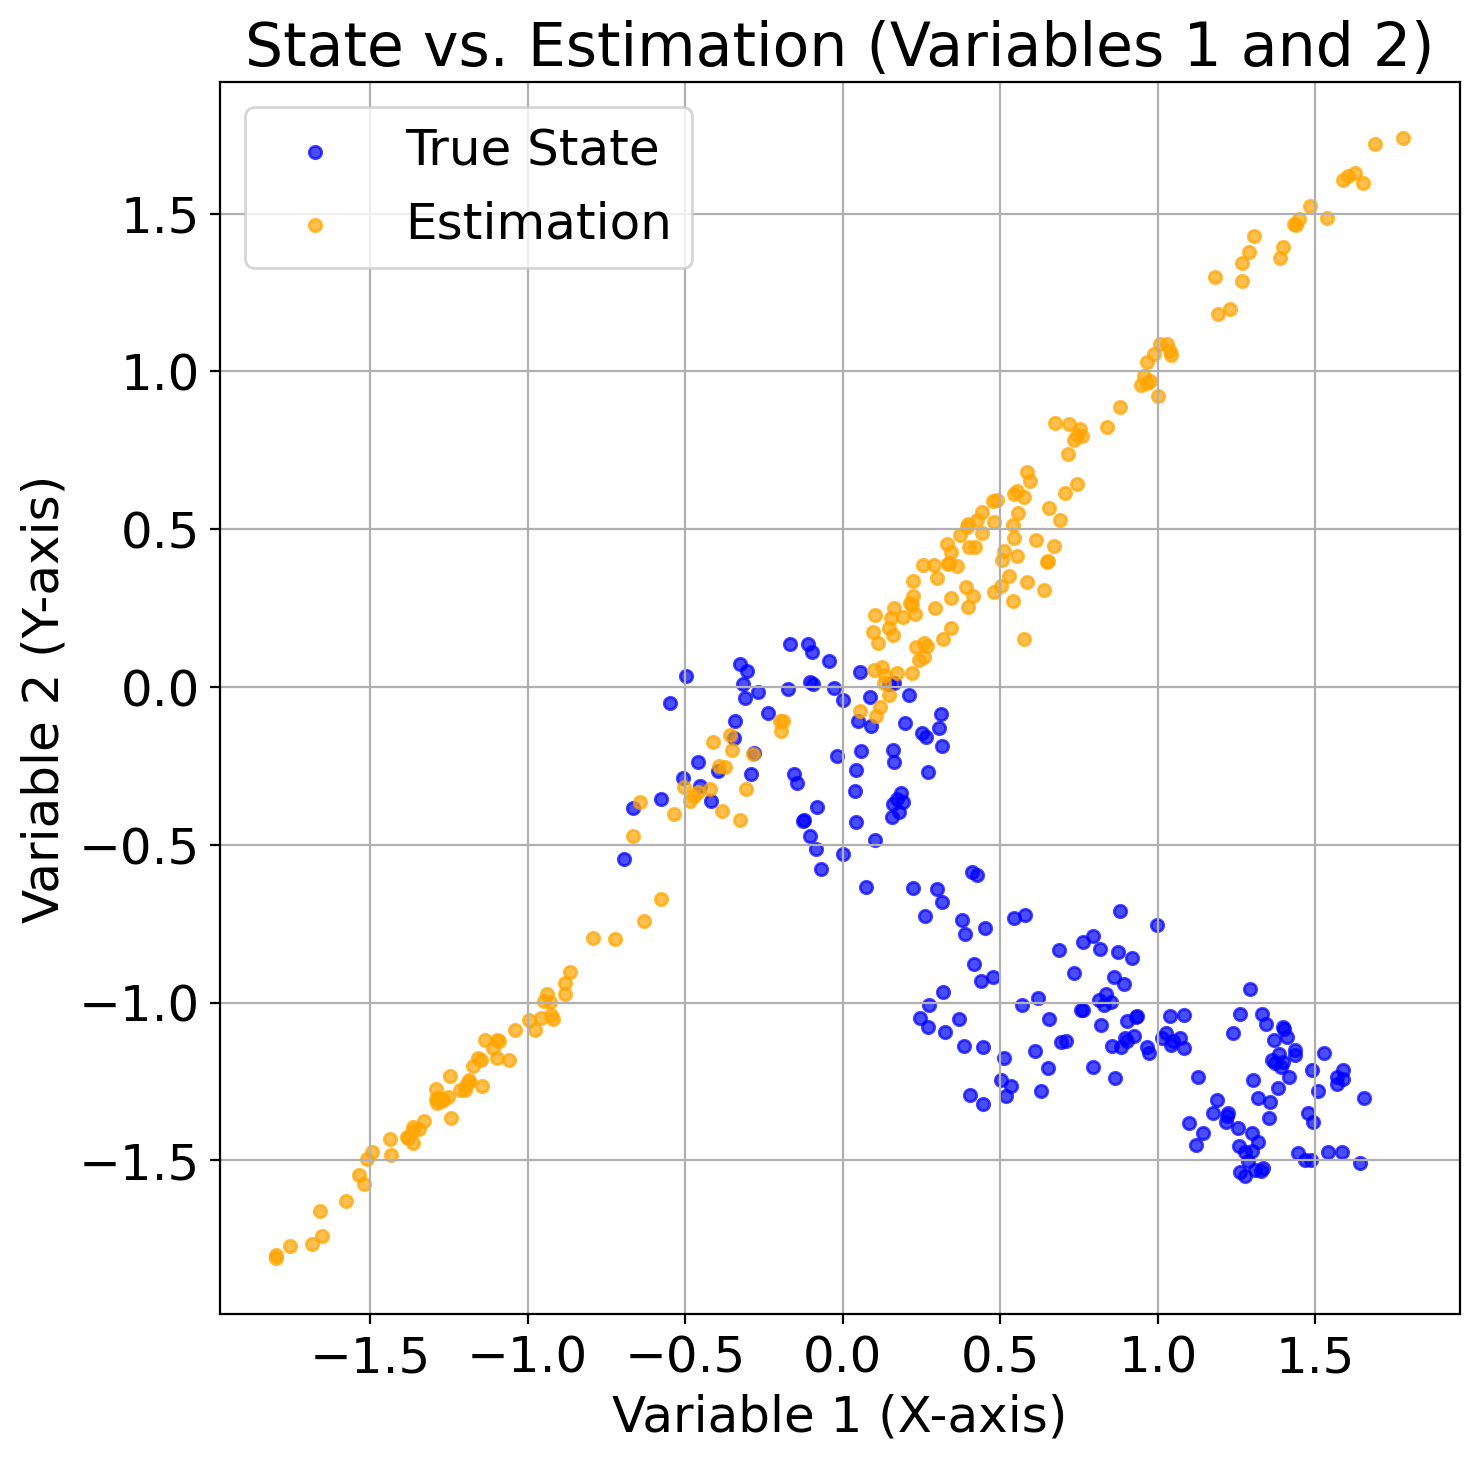

In [115]:
trial_index = 7
state_x = states[trial_index, :, 2]  # Variable 1 as x-axis
state_y = states[trial_index, :, 3]  # Variable 2 as y-axis
estimation_x = estimations[trial_index, :, 2]  # Variable 1 as x-axis
estimation_y = estimations[trial_index, :, 3]  # Variable 2 as y-axis

# Create a scatter plot for states and estimations
plt.figure(figsize=(8, 8))
plt.scatter(state_x, state_y, label='True State', color='blue', alpha=0.7, s=20)
plt.scatter(estimation_x, estimation_y, label='Estimation', color='orange', alpha=0.7, s=20)

plt.title('State vs. Estimation (Variables 1 and 2)')
plt.xlabel('Variable 1 (X-axis)')
plt.ylabel('Variable 2 (Y-axis)')
plt.legend()
plt.grid(True)

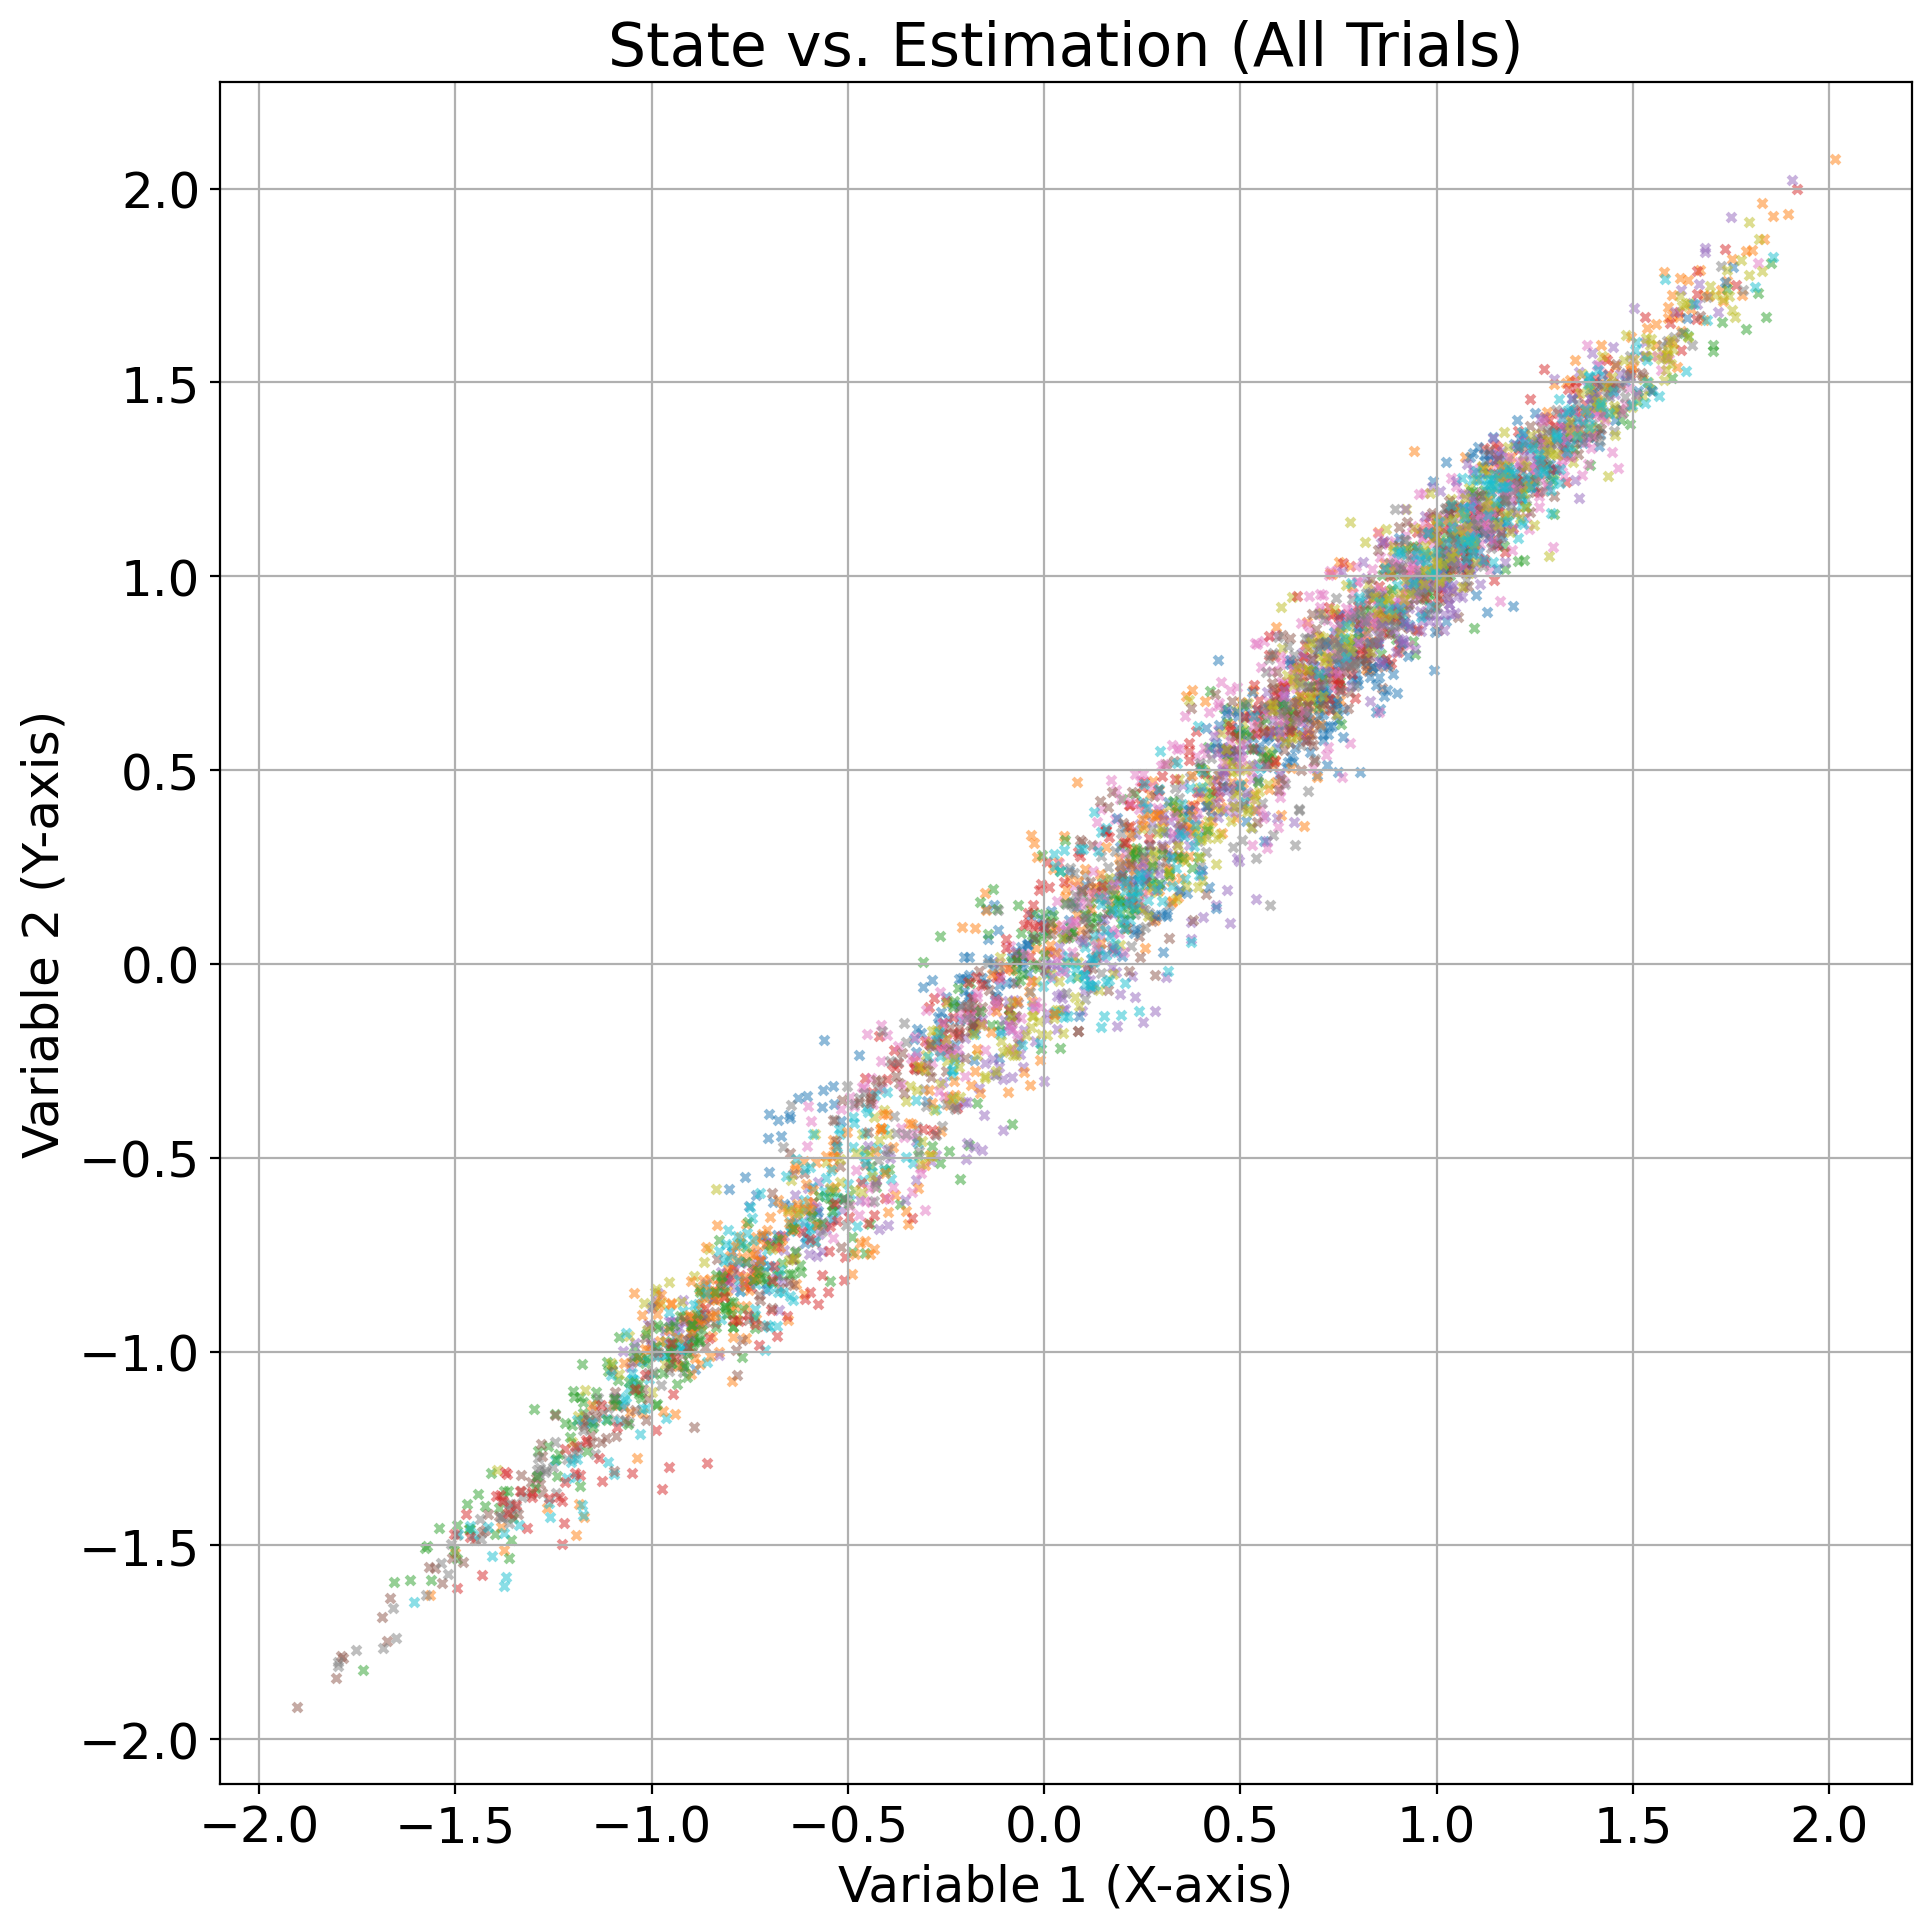

In [116]:
plt.figure(figsize=(10, 10))

# Iterate over all trials
for trial_idx in range(states.shape[0]):
    # Extract data for state and estimation
    state_x = states[trial_idx, :, 2]
    state_y = states[trial_idx, :, 3]
    estimation_x = estimations[trial_idx, :, 2]
    estimation_y = estimations[trial_idx, :, 3]
    
    # Plot state and estimation with different markers
    # plt.scatter(state_x, state_y, alpha=0.5, label=f'Trial {trial_idx + 1} - State', s=10)
    plt.scatter(estimation_x, estimation_y, alpha=0.5, label=f'Trial {trial_idx + 1} - Estimation', marker='x', s=10)

plt.title('State vs. Estimation (All Trials)')
plt.xlabel('Variable 1 (X-axis)')
plt.ylabel('Variable 2 (Y-axis)')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.grid(True)
plt.tight_layout()

In [117]:
# Data preparation
data = {
    "System": ["selkov", "oscillator", "hopf"],
    "SubSystem": [
        [1, 5, 7, 9, 10],  # selkov subsystems
        [1, 5, 7, 9, 10],  # oscillator subsystems
        [1, 5, 7, 9, 10],  # hopf subsystems
        
    ],
    "EnKF": [
        [0.5978, 1.8626, 2.5496, 3.0952, 3.5625],  # selkov
        [0.5505, 1.163, 1.3267, 1.4701, 1.6154],   # oscillator
        [0.6322, 0.9946, 1.0549, 1.0898, 1.1146],  # hopf
    ],
    "EnKFI": [
        [0.6703, 1.9874, 3.4248, 4.3829, 4.8417],
        [0.5516, 1.2714, 1.3195, 3.1428, 1.604],
        [0.6983, 1.1299, 1.1657, 1.1872, 1.1989],
    ],
    "EnKFS": [
        [0.6081, 1.6523, np.nan, 3.1699, 4.3972],
        [0.5548, 1.1674, 1.3575, 1.4757, 1.5793],
        [0.6380, 0.9938, 1.2035, 1.5071, 2.1321],
    ],
    "HubEnKF": [
        [0.6676, 2.1998, 2.5318, 2.8636, 2.985],
        [0.554, 1.1746, 1.4778, 1.8707, 2.168],
        [0.6982, 1.0976, 1.1155, 1.1313, 1.1483],
    ],
    "PF": [
        [0.3298, np.nan, np.nan, np.nan, np.nan],
        [0.4192, np.nan, np.nan, np.nan, np.nan],
        [0.4278, np.nan, np.nan, np.nan, np.nan],
    ],
    "KalmanNet": [
        [0.4443, np.nan, np.nan, np.nan, np.nan],
        [0.5665, np.nan, np.nan, np.nan, np.nan],
        [1.1984, 2.2308, 2.6285, 2.8964, 3.1207],
    ],
    "LLM-Filter": [
        [0.4061, 0.6898, 0.7034, 0.7074, 0.709],
        [0.5247, 0.5946, 0.6044, 0.6083, 0.611],
        [0.5751, 0.7142, 0.7738, 0.801, 0.8096],
    ],
}

methods = ["EnKF", "EnKFI", "EnKFS", "HubEnKF", "PF", "KalmanNet", "LLM-Filter"]
cmap = {
    "LLM-Filter": "lightseagreen",
    "KalmanNet": "darkorange",
    "EnKF": "dodgerblue",
    "EnKFI": "mediumslateblue",
    "EnKFS": "limegreen",
    "HubEnKF": "gold",
    "PF": "#dda0dd",
}

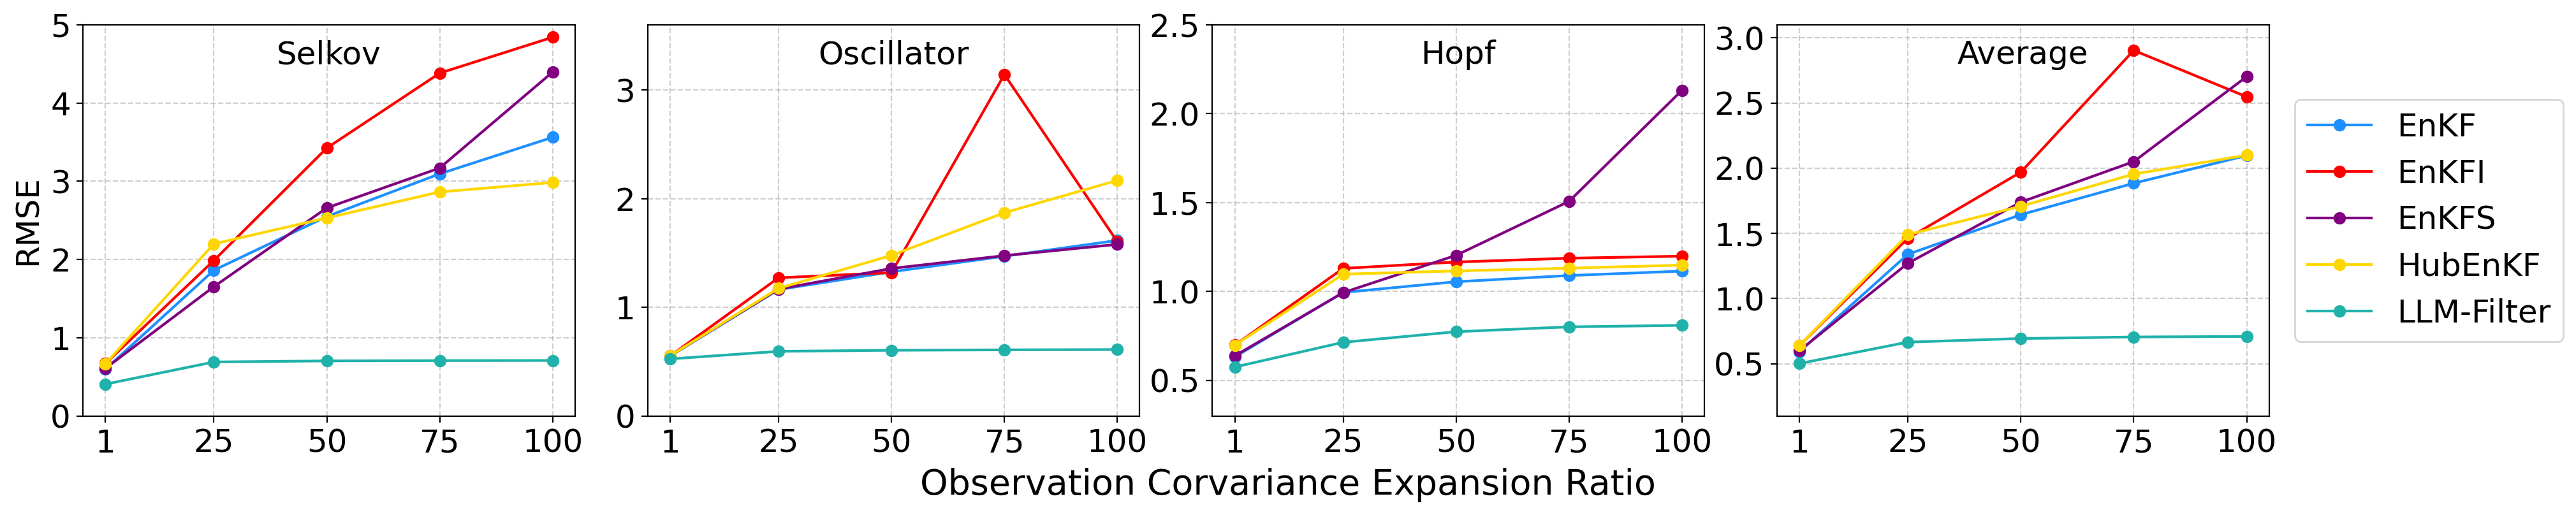

In [140]:


# List of systems
systems = ["Selkov", "Oscillator", "Hopf", "Average"]
subsystems = [
    [1, 25, 50, 75, 100],  # selkov
    [1, 25, 50, 75, 100],  # oscillator
    [1, 25, 50, 75, 100],  # hopf
    [1, 25, 50, 75, 100],  # 
]
# [r'$R$', r'$25R_0$', r'$50R_0$', r'$75R_0$', r'$100R_0$'],  # selkov
# [r'$R$', r'$25R_0$', r'$50R_0$', r'$75R_0$', r'$100R_0$'],  # oscillator
# [r'$R$', r'$25R_0$', r'$50R_0$', r'$75R_0$', r'$100R_0$'],  # hopf
# [r'$R$', r'$25R_0$', r'$50R_0$', r'$75R_0$', r'$100R_0$'],  # 

# Colors for each method
cmap = {
    "LLM-Filter": "lightseagreen",
    "KalmanNet": "darkorange",
    "EnKF": "dodgerblue",
    "EnKFI": "red",
    "EnKFS": "purple",
    "HubEnKF": "gold",
    "PF": "pink",
}

# Data values
methods = ["EnKF", "EnKFI", "EnKFS", "HubEnKF", "LLM-Filter"]
values = {
    "Selkov": {
        "EnKF": [0.5978, 1.8626, 2.5496, 3.0952, 3.5625],
        "EnKFI": [0.6703, 1.9874, 3.4248, 4.3829, 4.8417],
        "EnKFS": [0.6081, 1.6523, 2.6597, 3.1699, 4.3972],
        "HubEnKF": [0.6676, 2.1998, 2.5318, 2.8636, 2.9850],
        # "PF": [0.3298, np.nan, np.nan, np.nan, np.nan],
        # "KalmanNet": [0.4443, np.nan, np.nan, np.nan, np.nan],
        "LLM-Filter": [0.4061, 0.6898, 0.7034, 0.7074, 0.7090],
    },
    "Oscillator": {
        "EnKF": [0.5505, 1.163, 1.3267, 1.4701, 1.6154],
        "EnKFI": [0.5516, 1.2714, 1.3195, 3.1428, 1.6040],
        "EnKFS": [0.5548, 1.1674, 1.3575, 1.4757, 1.5793],
        "HubEnKF": [0.5540, 1.1746, 1.4778, 1.8707, 2.1680],
        # "PF": [0.4192, np.nan, np.nan, np.nan, np.nan],
        # "KalmanNet": [0.5665, np.nan, np.nan, np.nan, np.nan],
        "LLM-Filter": [0.5247, 0.5946, 0.6044, 0.6083, 0.6110],
    },
    "Hopf": {
        "EnKF": [0.6322, 0.9946, 1.0549, 1.0898, 1.1146],
        "EnKFI": [0.6983, 1.1299, 1.1657, 1.1872, 1.1989],
        "EnKFS": [0.6380, 0.9938, 1.2035, 1.5071, 2.1321],
        "HubEnKF": [0.6982, 1.0976, 1.1155, 1.1313, 1.1483],
        # "PF": [0.4278, np.nan, np.nan, np.nan, np.nan],
        # "KalmanNet": [1.1984, 2.2308, 2.6285, 2.8964, 3.1207],
        "LLM-Filter": [0.5751, 0.7142, 0.7738, 0.8010, 0.8096],
    },
}
values["Average"] = {
    "EnKF": [
        np.float64(0.5935),
        np.float64(1.3400666666666667),
        np.float64(1.6437333333333333),
        np.float64(1.8850333333333336),
        np.float64(2.0975)
    ],
    "EnKFI": [
        np.float64(0.6400666666666667),
        np.float64(1.4629),
        np.float64(1.97),
        np.float64(2.9043000000000005),
        np.float64(2.5482)
    ],
    "EnKFS": [
        np.float64(0.6003),
        np.float64(1.2711666666666668),
        np.float64(1.7402333333333333),
        np.float64(2.0509),
        np.float64(2.7028666666666665)
    ],
    "HubEnKF": [
        np.float64(0.6399333333333334),
        np.float64(1.4906666666666668),
        np.float64(1.7083666666666666),
        np.float64(1.9552000000000003),
        np.float64(2.1004333333333336)
    ],
    "LLM-Filter": [
        np.float64(0.5019666666666667),
        np.float64(0.6662),
        np.float64(0.6938666666666666),
        np.float64(0.7055666666666668),
        np.float64(0.7098666666666666)
    ]
}
# Colors for each method
cmap = {
    "LLM-Filter": "lightseagreen",
    "KalmanNet": "darkorange",
    "EnKF": "dodgerblue",
    "EnKFI": "red",
    "EnKFS": "purple",
    "HubEnKF": "gold",
    "PF": "pink",
}

fig, axs = plt.subplots(1, 4, figsize=(20, 3.5), sharey=False)
fontsize = 18
# fig, axs = plt.subplots(nrows=1, ncols=3, sharey=False)  # Ensure no shared y-axis
for idx, system in enumerate(systems):
    ax = axs[idx]
    for method in methods:
        ax.plot(
            subsystems[idx],
            values[system][method],
            label=method,
            color=cmap[method],
            marker="o",
        )
    # ax.set_title(system.capitalize(), fontsize=fontsize)
    # Place title inside each subplot using ax.text
    ax.text(0.5, 0.9, system.capitalize(), fontsize=fontsize, ha='center', transform=ax.transAxes)
    # ax.set_xlabel('Observation Corvariance Expansion Ratio', fontsize=fontsize)
    # Set x-axis ticks
    ax.set_xticks(subsystems[idx])  # The positions of the ticks
    # ax.set_xticklabels([r'$R$', r'$25R_0$', r'$50R_0$', r'$75R_0$', r'$100R_0$'])  # Labels as LaTeX formulas
    ax.set_xticklabels([r'1', r'25', r'50', r'75', r'100'])  # Labels as LaTeX formulas
    ax.tick_params(axis='x', labelsize=fontsize)
    
    ax.grid(True, linestyle="--", alpha=0.6)
    if idx==0:
        ax.set_ylim(0, 5)  # Adjust y-axis limits 
        ax.set_ylabel("RMSE", fontsize=fontsize)
    elif idx==1:
        ax.set_ylim(0, 3.6)
    elif idx==2:
        ax.set_ylim(0.3, 2.5)
    elif idx==3:
        ax.set_ylim(0.1, 3.1)
        # ax.legend(fontsize=fontsize, loc="upper left")
    if idx == 3:
        ax.legend(
            fontsize=fontsize,
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),  # Place legend to the right of the plot
            frameon=True,  # Remove the box around the legend
        )
        # ax.legend(
        #     fontsize=fontsize,
        #     frameon=True,  # Remove the box around the legend
        # )
    else:
        ax.legend().remove()  # Remove legends from the first two subplots    
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.yaxis.set_tick_params(labelleft=True)
    
fig.text(0.5, -0.08, 'Observation Corvariance Expansion Ratio', ha='center', fontsize=fontsize+2)
plt.subplots_adjust(wspace=0.1)  # Adjust the horizontal space between subplots
plt.tight_layout(pad=0.0)
plt.savefig('/home/liushiqi/lsq/LLM-Filter/plot/figures/cross_obs_noise.pdf', dpi=300, bbox_inches='tight')

In [119]:
# Add "Average" as a new system for each method's mean across the three systems for each corresponding subsystem
values["Average"] = {}

# Calculate the average for each method across all systems for each corresponding subsystem
methods = ["EnKF", "EnKFI", "EnKFS", "HubEnKF", "LLM-Filter"]
subsystems_count = len(values["Selkov"]["EnKF"])  # Number of subsystems (assuming all systems have the same number of subsystems)

for method in methods:
    # Initialize an empty list to hold the average values
    avg_values = []
    for i in range(subsystems_count):  # Loop through each subsystem (index)
        # Calculate the average for the current subsystem across all systems
        avg_value = np.mean([values[sys][method][i] for sys in values.keys() if sys != "Average"])
        avg_values.append(avg_value)
    values["Average"][method] = avg_values  # Store the average values

# Printing the updated dictionary with "Average"
for system in values:
    print(f"{system}: {values[system]}")

Selkov: {'EnKF': [0.5978, 1.8626, 2.5496, 3.0952, 3.5625], 'EnKFI': [0.6703, 1.9874, 3.4248, 4.3829, 4.8417], 'EnKFS': [0.6081, 1.6523, 2.6597, 3.1699, 4.3972], 'HubEnKF': [0.6676, 2.1998, 2.5318, 2.8636, 2.985], 'LLM-Filter': [0.4061, 0.6898, 0.7034, 0.7074, 0.709]}
Oscillator: {'EnKF': [0.5505, 1.163, 1.3267, 1.4701, 1.6154], 'EnKFI': [0.5516, 1.2714, 1.3195, 3.1428, 1.604], 'EnKFS': [0.5548, 1.1674, 1.3575, 1.4757, 1.5793], 'HubEnKF': [0.554, 1.1746, 1.4778, 1.8707, 2.168], 'LLM-Filter': [0.5247, 0.5946, 0.6044, 0.6083, 0.611]}
Hopf: {'EnKF': [0.6322, 0.9946, 1.0549, 1.0898, 1.1146], 'EnKFI': [0.6983, 1.1299, 1.1657, 1.1872, 1.1989], 'EnKFS': [0.638, 0.9938, 1.2035, 1.5071, 2.1321], 'HubEnKF': [0.6982, 1.0976, 1.1155, 1.1313, 1.1483], 'LLM-Filter': [0.5751, 0.7142, 0.7738, 0.801, 0.8096]}
Average: {'EnKF': [np.float64(0.5935), np.float64(1.3400666666666667), np.float64(1.6437333333333333), np.float64(1.8850333333333336), np.float64(2.0975)], 'EnKFI': [np.float64(0.6400666666666667),